# Sky Matching 

<div class="alert-danger">Note: The notebook in this repository 'Initialization.ipynb' goes over many of the basic concepts such as the setup of the environment/package installation and should be read first if you are new to HST images, DrizzlePac, or Astroquery.</div>

## Introduction

When a user decided to mosaic several images it can be difficult to decide how to relate the background of one image to the others. AstroDrizzle has the ability to compute and then either subtract or equalize the background in input images in order to match the sky between those images. The function allows users to select the algorithm for the sky subtraction using the `skymethod` parameter. 

There are four methods available in sky matching: 'localmin', 'match', 'globalmin', 'globalmin+match'.

By applying `drizzlepac.sky.sky()`, or by applying the `skymethod` parameter in the call to `drizzlepac.astrodrizzle.AstroDrizzle()`, AstroDrizzle will update the keyword `MDRIZSKY` in the headers of the input files. 

The **recommended** use for images with sparse fields that have few astronomical sources is `skymethod = localmin` and for images with complicated backgrounds, such as nebulae and large host galaxies, `skymethod = match` is recommended.

For more information on the specifics of this function please refer to the documentation [here](https://drizzlepac.readthedocs.io/en/deployment/sky.html#drizzlepac.sky.sky).

Below, each of the four methods will be demonstrated using a single example dataset, and differences between the methods will be highlighted. 

In [1]:
# All imports needed through out this notebook are included at the beginning. 
import glob
import os
import shutil
from shutil import copyfile

from astropy.io import fits
from astropy.visualization import astropy_mpl_style
from astroquery.mast import Observations
from ccdproc import ImageFileCollection
from IPython.display import Image
import matplotlib.pyplot as plt
import pandas as pd

import drizzlepac
from drizzlepac import tweakreg
from drizzlepac import tweakback
from stwcs import updatewcs 

The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       imagefindpars           mapreg              photeq       
     pixreplace           pixtopix            pixtosky        refimagefindpars  
     resetbits          runastrodriz          skytopix           tweakback      
      tweakreg           updatenpol


## 1. Retrieve Observations using Astroquery

WFC3/IR observations of the Horsehead Nebula obtained in HST proposal 12812 (PI: Levay) will be used for this demonstration. The images have been processed by the HST WFC3 pipeline (calwf3), which includes bias subtraction, dark current correction, cosmic-ray rejection, and flatfielding.

The alignment specifics for this example are based on the example found [here](https://archive.stsci.edu/prepds/heritage/horsehead/readme_HLSP_v3.txt). We will provide explanation about the process as we go. 

The code used to retrieve the data from astroquery is below.

In [2]:
# Retrieve the observation information.
obs_table = Observations.query_criteria(proposal_id='12812', filters=["F160W"], project='HST')
obs_table.show_in_notebook()

# Figure out the downloadable products:
dataProductsByObservation = Observations.get_product_list(obs_table)
dataProductsByObservation.show_in_notebook()

# Download the flc.fits files: 
obsids = obs_table['obsid']

# Download the data - uncomment to download: 
Observations.download_products(obsids, mrp_only=False, productSubGroupDescription=['FLT', 'DRZ'])

 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


Local Path,Status,Message,URL
str47,str8,object,object
./mastDownload/HST/ibxl52030/ibxl52030_drz.fits,COMPLETE,None,None
./mastDownload/HST/ibxl52k0q/ibxl52k0q_flt.fits,COMPLETE,None,None
./mastDownload/HST/ibxl52k5q/ibxl52k5q_flt.fits,COMPLETE,None,None
./mastDownload/HST/ibxl57030/ibxl57030_drz.fits,COMPLETE,None,None
./mastDownload/HST/ibxl57adq/ibxl57adq_flt.fits,COMPLETE,None,None
./mastDownload/HST/ibxl57aiq/ibxl57aiq_flt.fits,COMPLETE,None,None
./mastDownload/HST/ibxl56030/ibxl56030_drz.fits,COMPLETE,None,None
./mastDownload/HST/ibxl56huq/ibxl56huq_flt.fits,COMPLETE,None,None
./mastDownload/HST/ibxl56i2q/ibxl56i2q_flt.fits,COMPLETE,None,None


### Move files to the local directory 

In [3]:
flt_files = glob.glob('mastDownload/*/*/*flt.fits')

for file in flt_files:
    im = fits.open(file)
    rootname = im[0].header['ROOTNAME']
    im.close()
    dst = rootname + "_flt.fits"
    copyfile(file, dst)

drz_files = glob.glob('mastDownload/*/*/*drz.fits')

for file in drz_files:
    im = fits.open(file)
    rootname = im[0].header['ROOTNAME']
    im.close()
    dst = rootname + "_drz.fits"
    copyfile(file, dst)

### Inspect the image headers

In [4]:
collect_flt = ImageFileCollection('./', glob_include="*flt.fits", ext=0,
                                  keywords=["asn_id", "detector", "filter", "exptime", "postarg1", "postarg2"])
    
flt_table = collect_flt.summary
flt_table['exptime'].format = '7.1f'
flt_table['postarg1'].format = '7.2f'
flt_table['postarg2'].format = '7.2f'
flt_table

file,asn_id,detector,filter,exptime,postarg1,postarg2
str18,str9,str2,str5,float64,float64,float64
ibxl50clq_flt.fits,IBXL50030,IR,F160W,702.9,-123.74,-113.11
ibxl50cqq_flt.fits,IBXL50030,IR,F160W,702.9,-123.74,-105.91
ibxl51eoq_flt.fits,IBXL51030,IR,F160W,702.9,0.00,-113.11
ibxl51etq_flt.fits,IBXL51030,IR,F160W,702.9,0.00,-105.91
ibxl52k0q_flt.fits,IBXL52030,IR,F160W,702.9,123.74,-113.11
ibxl52k5q_flt.fits,IBXL52030,IR,F160W,702.9,123.74,-105.91
ibxl53kxq_flt.fits,IBXL53030,IR,F160W,702.9,-123.74,-3.60
ibxl53l9q_flt.fits,IBXL53030,IR,F160W,702.9,-123.74,3.60
ibxl54bgq_flt.fits,IBXL54030,IR,F160W,702.9,0.00,-3.60


In [5]:
collect_drz = ImageFileCollection('./', glob_include="*drz.fits", ext=0,
                                  keywords=["asn_id", "detector", "filter", "exptime"])
    
drz_table = collect_drz.summary
drz_table['exptime'].format = '7.1f'
drz_table

file,asn_id,detector,filter,exptime
str18,str9,str2,str5,float64
ibxl50030_drz.fits,IBXL50030,IR,F160W,1405.9
ibxl51030_drz.fits,IBXL51030,IR,F160W,1405.9
ibxl52030_drz.fits,IBXL52030,IR,F160W,1405.9
ibxl53030_drz.fits,IBXL53030,IR,F160W,1405.9
ibxl54030_drz.fits,IBXL54030,IR,F160W,1405.9
ibxl55030_drz.fits,IBXL55030,IR,F160W,1405.9
ibxl56030_drz.fits,IBXL56030,IR,F160W,1405.9
ibxl57030_drz.fits,IBXL57030,IR,F160W,1405.9
ibxl58030_drz.fits,IBXL58030,IR,F160W,1405.9


## 2. Align the visit-level drizzled data

Exposures obtained within a single HST visit tend to be aligned very well since they use the same guide stars. Thus, we will use TweakReg to align the DRZ files and then use TweakBack to propagate those solutions back to the FLT image headers prior to combining with AstroDrizzle. Making use of the parameter `expand_refcat`, TweakReg will build up an expanded reference catalog on the sky to be used for alignment. For this dataset, we obtain the best results when we tell TweakReg to align the DRZ files in a specific order, and this is achieved by giving a list of files as input. More details on alignment of HST mosaics can be found in the notebook 'mosaics.ipynb' in this repository.
    
    drz.list
    ibxl54030_drz.fits	<-- Note that tile 54 is the reference and is listed first
    ibxl51030_drz.fits  
    ibxl53030_drz.fits
    ibxl55030_drz.fits
    ibxl57030_drz.fits
    ibxl50030_drz.fits
    ibxl52030_drz.fits
    ibxl56030_drz.fits
    ibxl58030_drz.fits
      ____ ____ ____
     |    |    |    |    <-- The 4 tiles with the most overlap are aligned first
     |    | 55 |    |
     |____|____|____|
     |    |    |    |
     | 57 | 54 | 51 |
     |____|____|____|
     |    |    |    |
     |    | 53 |    |
     |____|____|____|
   
      ____ ____ ____
     |    |    |    |    <-- Then the corner tiles are added 
     | 58 |    | 52 |
     |____|____|____|
     |    |    |    |
     |    |    |    |
     |____|____|____|
     |    |    |    |
     | 56 |    | 50 |
     |____|____|____|

This allows TweakReg to start with the tiles with the most overlap first and then build upon that, expanding the reference catalog as each new tile is aligned. 

INFO:drizzlepac.util:Setting up logfile :  tweakreg.log


Setting up logfile :  tweakreg.log


INFO:drizzlepac.tweakreg:TweakReg Version 1.4.7(18-April-2018) started at: 15:04:30.007 (10/05/2019) 


TweakReg Version 1.4.7(18-April-2018) started at: 15:04:30.007 (10/05/2019) 


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.util:Version Information


Version Information


INFO:drizzlepac.util:--------------------


--------------------


INFO:drizzlepac.util:Python Version [GCC 7.3.0]


Python Version [GCC 7.3.0]


INFO:drizzlepac.util:3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 


3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 


INFO:drizzlepac.util:numpy Version -> 1.15.4 


numpy Version -> 1.15.4 


INFO:drizzlepac.util:astropy Version -> 3.1.2 


astropy Version -> 3.1.2 


INFO:drizzlepac.util:stwcs Version -> 1.4.2 


stwcs Version -> 1.4.2 


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS common to all Processing Steps:


INFO:drizzlepac.tweakreg:	clean :	False


INFO:drizzlepac.tweakreg:	enforce_user_order :	True


INFO:drizzlepac.tweakreg:	exclusions :	


INFO:drizzlepac.tweakreg:	expand_refcat :	True


INFO:drizzlepac.tweakreg:	input :	@drz.list


INFO:drizzlepac.tweakreg:	interactive :	False


INFO:drizzlepac.tweakreg:	refimage :	


INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log


INFO:drizzlepac.tweakreg:	updatewcs :	False


INFO:drizzlepac.tweakreg:	verbose :	False


INFO:drizzlepac.tweakreg:	writecat :	True


INFO:drizzlepac.tweakutils:ibxl54030_drz.fits


ibxl54030_drz.fits


INFO:drizzlepac.tweakutils:


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:Finding shifts for: 


Finding shifts for: 


INFO:drizzlepac.tweakreg:    ibxl54030_drz.fits


    ibxl54030_drz.fits


INFO:drizzlepac.tweakreg:    ibxl51030_drz.fits


    ibxl51030_drz.fits


INFO:drizzlepac.tweakreg:    ibxl53030_drz.fits


    ibxl53030_drz.fits


INFO:drizzlepac.tweakreg:    ibxl55030_drz.fits


    ibxl55030_drz.fits


INFO:drizzlepac.tweakreg:    ibxl57030_drz.fits


    ibxl57030_drz.fits


INFO:drizzlepac.tweakreg:    ibxl50030_drz.fits


    ibxl50030_drz.fits


INFO:drizzlepac.tweakreg:    ibxl52030_drz.fits


    ibxl52030_drz.fits


INFO:drizzlepac.tweakreg:    ibxl56030_drz.fits


    ibxl56030_drz.fits


INFO:drizzlepac.tweakreg:    ibxl58030_drz.fits


    ibxl58030_drz.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for each input image:


INFO:drizzlepac.tweakreg:	clean :	False


INFO:drizzlepac.tweakreg:	computesig :	True


INFO:drizzlepac.tweakreg:	conv_width :	4.5


INFO:drizzlepac.tweakreg:	dqbits :	


INFO:drizzlepac.tweakreg:	enforce_user_order :	True


INFO:drizzlepac.tweakreg:	expand_refcat :	True


INFO:drizzlepac.tweakreg:	fluxmax :	None


INFO:drizzlepac.tweakreg:	fluxmin :	None


INFO:drizzlepac.tweakreg:	input :	@drz.list


INFO:drizzlepac.tweakreg:	interactive :	False


INFO:drizzlepac.tweakreg:	nsigma :	1.5


INFO:drizzlepac.tweakreg:	peakmax :	None


INFO:drizzlepac.tweakreg:	peakmin :	1


INFO:drizzlepac.tweakreg:	ratio :	1.0


INFO:drizzlepac.tweakreg:	refimage :	


INFO:drizzlepac.tweakreg:	roundhi :	1.0


INFO:drizzlepac.tweakreg:	roundlo :	-1.0


INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log


INFO:drizzlepac.tweakreg:	sharphi :	1.0


INFO:drizzlepac.tweakreg:	sharplo :	0.2


INFO:drizzlepac.tweakreg:	skysigma :	0.0


INFO:drizzlepac.tweakreg:	theta :	0.0


INFO:drizzlepac.tweakreg:	threshold :	10


INFO:drizzlepac.tweakreg:	updatehdr :	True


INFO:drizzlepac.tweakreg:	updatewcs :	False


INFO:drizzlepac.tweakreg:	use_sharp_round :	False


INFO:drizzlepac.tweakreg:	verbose :	False


INFO:drizzlepac.tweakreg:	writecat :	True


INFO:drizzlepac.tweakreg:	xyunits :	pixels


INFO:drizzlepac.tweakreg:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.imgclasses:===  Source finding for image 'ibxl54030_drz.fits':


===  Source finding for image 'ibxl54030_drz.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ibxl54030_drz.fits', EXT=('SCI', 1) started at: 15:04:30.47 (10/05/2019)


  #  Source finding for 'ibxl54030_drz.fits', EXT=('SCI', 1) started at: 15:04:30.47 (10/05/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 1.543311


  tdata=np.where(convdata > threshold, convdata, 0)



INFO:drizzlepac.catalogs:###Source finding finished at: 15:04:30.586 (10/05/2019)


INFO:drizzlepac.catalogs:     Found 38 objects.


     Found 38 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ibxl54030_drz.fits': 38


===  FINAL number of objects in image 'ibxl54030_drz.fits': 38


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ibxl51030_drz.fits':


===  Source finding for image 'ibxl51030_drz.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ibxl51030_drz.fits', EXT=('SCI', 1) started at: 15:04:30.799 (10/05/2019)


  #  Source finding for 'ibxl51030_drz.fits', EXT=('SCI', 1) started at: 15:04:30.799 (10/05/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 1.553781


INFO:drizzlepac.catalogs:###Source finding finished at: 15:04:30.945 (10/05/2019)


INFO:drizzlepac.catalogs:     Found 52 objects.


     Found 52 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ibxl51030_drz.fits': 52


===  FINAL number of objects in image 'ibxl51030_drz.fits': 52


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ibxl53030_drz.fits':


===  Source finding for image 'ibxl53030_drz.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ibxl53030_drz.fits', EXT=('SCI', 1) started at: 15:04:31.185 (10/05/2019)


  #  Source finding for 'ibxl53030_drz.fits', EXT=('SCI', 1) started at: 15:04:31.185 (10/05/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 1.527635


INFO:drizzlepac.catalogs:###Source finding finished at: 15:04:31.291 (10/05/2019)


INFO:drizzlepac.catalogs:     Found 36 objects.


     Found 36 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ibxl53030_drz.fits': 36


===  FINAL number of objects in image 'ibxl53030_drz.fits': 36


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ibxl55030_drz.fits':


===  Source finding for image 'ibxl55030_drz.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ibxl55030_drz.fits', EXT=('SCI', 1) started at: 15:04:31.50 (10/05/2019)


  #  Source finding for 'ibxl55030_drz.fits', EXT=('SCI', 1) started at: 15:04:31.50 (10/05/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 1.259246


INFO:drizzlepac.catalogs:###Source finding finished at: 15:04:31.600 (10/05/2019)


INFO:drizzlepac.catalogs:     Found 55 objects.


     Found 55 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ibxl55030_drz.fits': 55


===  FINAL number of objects in image 'ibxl55030_drz.fits': 55


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ibxl57030_drz.fits':


===  Source finding for image 'ibxl57030_drz.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ibxl57030_drz.fits', EXT=('SCI', 1) started at: 15:04:31.816 (10/05/2019)


  #  Source finding for 'ibxl57030_drz.fits', EXT=('SCI', 1) started at: 15:04:31.816 (10/05/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 1.505249


INFO:drizzlepac.catalogs:###Source finding finished at: 15:04:31.901 (10/05/2019)


INFO:drizzlepac.catalogs:     Found 65 objects.


     Found 65 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ibxl57030_drz.fits': 65


===  FINAL number of objects in image 'ibxl57030_drz.fits': 65


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ibxl50030_drz.fits':


===  Source finding for image 'ibxl50030_drz.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ibxl50030_drz.fits', EXT=('SCI', 1) started at: 15:04:32.097 (10/05/2019)


  #  Source finding for 'ibxl50030_drz.fits', EXT=('SCI', 1) started at: 15:04:32.097 (10/05/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 1.553639


INFO:drizzlepac.catalogs:###Source finding finished at: 15:04:32.245 (10/05/2019)


INFO:drizzlepac.catalogs:     Found 57 objects.


     Found 57 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ibxl50030_drz.fits': 57


===  FINAL number of objects in image 'ibxl50030_drz.fits': 57


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ibxl52030_drz.fits':


===  Source finding for image 'ibxl52030_drz.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ibxl52030_drz.fits', EXT=('SCI', 1) started at: 15:04:32.41 (10/05/2019)


  #  Source finding for 'ibxl52030_drz.fits', EXT=('SCI', 1) started at: 15:04:32.41 (10/05/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 1.240202


INFO:drizzlepac.catalogs:###Source finding finished at: 15:04:32.49 (10/05/2019)


INFO:drizzlepac.catalogs:     Found 59 objects.


     Found 59 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ibxl52030_drz.fits': 59


===  FINAL number of objects in image 'ibxl52030_drz.fits': 59


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ibxl56030_drz.fits':


===  Source finding for image 'ibxl56030_drz.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ibxl56030_drz.fits', EXT=('SCI', 1) started at: 15:04:32.678 (10/05/2019)


  #  Source finding for 'ibxl56030_drz.fits', EXT=('SCI', 1) started at: 15:04:32.678 (10/05/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 1.619044


INFO:drizzlepac.catalogs:###Source finding finished at: 15:04:32.772 (10/05/2019)


INFO:drizzlepac.catalogs:     Found 47 objects.


     Found 47 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ibxl56030_drz.fits': 47


===  FINAL number of objects in image 'ibxl56030_drz.fits': 47


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ibxl58030_drz.fits':


===  Source finding for image 'ibxl58030_drz.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ibxl58030_drz.fits', EXT=('SCI', 1) started at: 15:04:32.987 (10/05/2019)


  #  Source finding for 'ibxl58030_drz.fits', EXT=('SCI', 1) started at: 15:04:32.987 (10/05/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 1.247739


INFO:drizzlepac.catalogs:###Source finding finished at: 15:04:33.086 (10/05/2019)


INFO:drizzlepac.catalogs:     Found 65 objects.


     Found 65 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ibxl58030_drz.fits': 65


===  FINAL number of objects in image 'ibxl58030_drz.fits': 65


INFO:drizzlepac.imgclasses:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.imgclasses:Converting RA/Dec positions of reference sources from "ibxl54030_drz.fits" to X,Y positions in reference WCS...


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:Performing alignment in the projection plane defined by the WCS


Performing alignment in the projection plane defined by the WCS


INFO:drizzlepac.tweakreg:derived from 'ibxl54030_drz.fits'


derived from 'ibxl54030_drz.fits'


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for matching sources:


INFO:drizzlepac.tweakreg:	minobj :	5


INFO:drizzlepac.tweakreg:	residplot :	both


INFO:drizzlepac.tweakreg:	searchrad :	3.0


INFO:drizzlepac.tweakreg:	searchunits :	arcseconds


INFO:drizzlepac.tweakreg:	see2dplot :	True


INFO:drizzlepac.tweakreg:	separation :	0.5


INFO:drizzlepac.tweakreg:	tolerance :	1.0


INFO:drizzlepac.tweakreg:	use2dhist :	True


INFO:drizzlepac.tweakreg:	xoffset :	0.0


INFO:drizzlepac.tweakreg:	yoffset :	0.0


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for fitting source lists:


INFO:drizzlepac.tweakreg:	fitgeometry :	rscale


INFO:drizzlepac.tweakreg:	labelsize :	8


INFO:drizzlepac.tweakreg:	minobj :	5


INFO:drizzlepac.tweakreg:	nclip :	3


INFO:drizzlepac.tweakreg:	residplot :	both


INFO:drizzlepac.tweakreg:	sigma :	3.0


INFO:drizzlepac.tweakreg:	ylimit :	0.5


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for creating a shiftfile:


INFO:drizzlepac.tweakreg:	outshifts :	shift4_drc.txt


INFO:drizzlepac.tweakreg:	outwcs :	shifts_wcs.fits


INFO:drizzlepac.tweakreg:	shiftfile :	True


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ibxl51030_drz.fits


Performing fit for: ibxl51030_drz.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ibxl51030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


Matching sources from 'ibxl51030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:stsci.imagestats:! WARNING: Clipped data falls within 1 histogram bin


! WARNING: Clipped data falls within 1 histogram bin


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -0.3918123436685583 -0.3918123436685583


Found initial X and Y shifts of  -0.3918123436685583 -0.3918123436685583


INFO:drizzlepac.tweakutils:    with significance of  92.951600308978 and  4.0  matches


    with significance of  92.951600308978 and  4.0  matches


INFO:drizzlepac.imgclasses:##############################################################################


##############################################################################


INFO:drizzlepac.imgclasses:#                                                                            #


#                                                                            #


INFO:drizzlepac.imgclasses:# WARNING:                                                                   #


# WARNING:                                                                   #


INFO:drizzlepac.imgclasses:# Not enough matches (< 5) found for input image: ibxl51030_drz.fits         #


# Not enough matches (< 5) found for input image: ibxl51030_drz.fits         #


INFO:drizzlepac.imgclasses:#                                                                            #


#                                                                            #


INFO:drizzlepac.imgclasses:##############################################################################


##############################################################################


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ibxl53030_drz.fits


Performing fit for: ibxl53030_drz.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ibxl53030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


Matching sources from 'ibxl53030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:stsci.imagestats:! WARNING: Clipped data falls within 1 histogram bin


! WARNING: Clipped data falls within 1 histogram bin


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -4.391812343668558 -0.3918123436685583


Found initial X and Y shifts of  -4.391812343668558 -0.3918123436685583


INFO:drizzlepac.tweakutils:    with significance of  80.49844718999243 and  3.0  matches


    with significance of  80.49844718999243 and  3.0  matches


INFO:drizzlepac.imgclasses:##############################################################################


##############################################################################


INFO:drizzlepac.imgclasses:#                                                                            #


#                                                                            #


INFO:drizzlepac.imgclasses:# WARNING:                                                                   #


# WARNING:                                                                   #


INFO:drizzlepac.imgclasses:# Not enough matches (< 5) found for input image: ibxl53030_drz.fits         #


# Not enough matches (< 5) found for input image: ibxl53030_drz.fits         #


INFO:drizzlepac.imgclasses:#                                                                            #


#                                                                            #


INFO:drizzlepac.imgclasses:##############################################################################


##############################################################################


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ibxl55030_drz.fits


Performing fit for: ibxl55030_drz.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ibxl55030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


Matching sources from 'ibxl55030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:stsci.imagestats:! WARNING: Clipped data falls within 1 histogram bin


! WARNING: Clipped data falls within 1 histogram bin


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -0.3918123436685583 -0.3918123436685583


Found initial X and Y shifts of  -0.3918123436685583 -0.3918123436685583


INFO:drizzlepac.tweakutils:    with significance of  92.951600308978 and  4.0  matches


    with significance of  92.951600308978 and  4.0  matches


INFO:drizzlepac.imgclasses:##############################################################################


##############################################################################


INFO:drizzlepac.imgclasses:#                                                                            #


#                                                                            #


INFO:drizzlepac.imgclasses:# WARNING:                                                                   #


# WARNING:                                                                   #


INFO:drizzlepac.imgclasses:# Not enough matches (< 5) found for input image: ibxl55030_drz.fits         #


# Not enough matches (< 5) found for input image: ibxl55030_drz.fits         #


INFO:drizzlepac.imgclasses:#                                                                            #


#                                                                            #


INFO:drizzlepac.imgclasses:##############################################################################


##############################################################################


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ibxl57030_drz.fits


Performing fit for: ibxl57030_drz.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ibxl57030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


Matching sources from 'ibxl57030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:stsci.imagestats:! WARNING: Clipped data falls within 1 histogram bin


! WARNING: Clipped data falls within 1 histogram bin


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -4.391812343668558 -2.3918123436685583


Found initial X and Y shifts of  -4.391812343668558 -2.3918123436685583


INFO:drizzlepac.tweakutils:    with significance of  65.72670690061993 and  2.0  matches


    with significance of  65.72670690061993 and  2.0  matches


INFO:drizzlepac.imgclasses:##############################################################################


##############################################################################


INFO:drizzlepac.imgclasses:#                                                                            #


#                                                                            #


INFO:drizzlepac.imgclasses:# WARNING:                                                                   #


# WARNING:                                                                   #


INFO:drizzlepac.imgclasses:# Not enough matches (< 5) found for input image: ibxl57030_drz.fits         #


# Not enough matches (< 5) found for input image: ibxl57030_drz.fits         #


INFO:drizzlepac.imgclasses:#                                                                            #


#                                                                            #


INFO:drizzlepac.imgclasses:##############################################################################


##############################################################################


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ibxl50030_drz.fits


Performing fit for: ibxl50030_drz.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ibxl50030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


Matching sources from 'ibxl50030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:stsci.imagestats:! WARNING: Clipped data falls within 1 histogram bin


! WARNING: Clipped data falls within 1 histogram bin


INFO:stsci.imagestats:! WARNING: Clipped data falls within 1 histogram bin


! WARNING: Clipped data falls within 1 histogram bin


  results = [sum(input * grids[dir].astype(float), labels, index) / normalizer for dir in range(input.ndim)]



INFO:stsci.imagestats:! WARNING: Clipped data falls within 1 histogram bin


! WARNING: Clipped data falls within 1 histogram bin


INFO:stsci.imagestats:! WARNING: Clipped data falls within 1 histogram bin


! WARNING: Clipped data falls within 1 histogram bin


INFO:drizzlepac.tweakutils:!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


INFO:drizzlepac.tweakutils:!


!


INFO:drizzlepac.tweakutils:! WARNING: No valid shift found within a search radius of  23.39181234366856  pixels.


! WARNING: No valid shift found within a search radius of  23.39181234366856  pixels.


INFO:drizzlepac.tweakutils:!


!


INFO:drizzlepac.tweakutils:!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


INFO:drizzlepac.imgclasses:##############################################################################


##############################################################################


INFO:drizzlepac.imgclasses:#                                                                            #


#                                                                            #


INFO:drizzlepac.imgclasses:# WARNING:                                                                   #


# WARNING:                                                                   #


INFO:drizzlepac.imgclasses:# Not enough matches (< 5) found for input image: ibxl50030_drz.fits         #


# Not enough matches (< 5) found for input image: ibxl50030_drz.fits         #


INFO:drizzlepac.imgclasses:#                                                                            #


#                                                                            #


INFO:drizzlepac.imgclasses:##############################################################################


##############################################################################


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ibxl52030_drz.fits


Performing fit for: ibxl52030_drz.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ibxl52030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


Matching sources from 'ibxl52030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:stsci.imagestats:! WARNING: Clipped data falls within 1 histogram bin


! WARNING: Clipped data falls within 1 histogram bin


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -4.391812343668558 -2.3918123436685583


Found initial X and Y shifts of  -4.391812343668558 -2.3918123436685583


INFO:drizzlepac.tweakutils:    with significance of  46.475800154489 and  1.0  matches


    with significance of  46.475800154489 and  1.0  matches


INFO:drizzlepac.imgclasses:##############################################################################


##############################################################################


INFO:drizzlepac.imgclasses:#                                                                            #


#                                                                            #


INFO:drizzlepac.imgclasses:# WARNING:                                                                   #


# WARNING:                                                                   #


INFO:drizzlepac.imgclasses:# Not enough matches (< 5) found for input image: ibxl52030_drz.fits         #


# Not enough matches (< 5) found for input image: ibxl52030_drz.fits         #


INFO:drizzlepac.imgclasses:#                                                                            #


#                                                                            #


INFO:drizzlepac.imgclasses:##############################################################################


##############################################################################


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ibxl56030_drz.fits


Performing fit for: ibxl56030_drz.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ibxl56030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


Matching sources from 'ibxl56030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:stsci.imagestats:! WARNING: Clipped data falls within 1 histogram bin


! WARNING: Clipped data falls within 1 histogram bin


INFO:stsci.imagestats:! WARNING: Clipped data falls within 1 histogram bin


! WARNING: Clipped data falls within 1 histogram bin


INFO:stsci.imagestats:! WARNING: Clipped data falls within 1 histogram bin


! WARNING: Clipped data falls within 1 histogram bin


INFO:stsci.imagestats:! WARNING: Clipped data falls within 1 histogram bin


! WARNING: Clipped data falls within 1 histogram bin


INFO:drizzlepac.tweakutils:!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


INFO:drizzlepac.tweakutils:!


!


INFO:drizzlepac.tweakutils:! WARNING: No valid shift found within a search radius of  23.39181234366856  pixels.


! WARNING: No valid shift found within a search radius of  23.39181234366856  pixels.


INFO:drizzlepac.tweakutils:!


!


INFO:drizzlepac.tweakutils:!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


INFO:drizzlepac.imgclasses:##############################################################################


##############################################################################


INFO:drizzlepac.imgclasses:#                                                                            #


#                                                                            #


INFO:drizzlepac.imgclasses:# WARNING:                                                                   #


# WARNING:                                                                   #


INFO:drizzlepac.imgclasses:# Not enough matches (< 5) found for input image: ibxl56030_drz.fits         #


# Not enough matches (< 5) found for input image: ibxl56030_drz.fits         #


INFO:drizzlepac.imgclasses:#                                                                            #


#                                                                            #


INFO:drizzlepac.imgclasses:##############################################################################


##############################################################################


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ibxl58030_drz.fits


Performing fit for: ibxl58030_drz.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ibxl58030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


Matching sources from 'ibxl58030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:stsci.imagestats:! WARNING: Clipped data falls within 1 histogram bin


! WARNING: Clipped data falls within 1 histogram bin


INFO:stsci.imagestats:! WARNING: Clipped data falls within 1 histogram bin


! WARNING: Clipped data falls within 1 histogram bin


INFO:stsci.imagestats:! WARNING: Clipped data falls within 1 histogram bin


! WARNING: Clipped data falls within 1 histogram bin


INFO:stsci.imagestats:! WARNING: Clipped data falls within 1 histogram bin


! WARNING: Clipped data falls within 1 histogram bin


INFO:drizzlepac.tweakutils:!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


INFO:drizzlepac.tweakutils:!


!


INFO:drizzlepac.tweakutils:! WARNING: No valid shift found within a search radius of  23.39181234366856  pixels.


! WARNING: No valid shift found within a search radius of  23.39181234366856  pixels.


INFO:drizzlepac.tweakutils:!


!


INFO:drizzlepac.tweakutils:!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


INFO:drizzlepac.imgclasses:##############################################################################


##############################################################################


INFO:drizzlepac.imgclasses:#                                                                            #


#                                                                            #


INFO:drizzlepac.imgclasses:# WARNING:                                                                   #


# WARNING:                                                                   #


INFO:drizzlepac.imgclasses:# Not enough matches (< 5) found for input image: ibxl58030_drz.fits         #


# Not enough matches (< 5) found for input image: ibxl58030_drz.fits         #


INFO:drizzlepac.imgclasses:#                                                                            #


#                                                                            #


INFO:drizzlepac.imgclasses:##############################################################################


##############################################################################


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:Unable to match the following images:


Unable to match the following images:


INFO:drizzlepac.tweakreg:-------------------------------------


-------------------------------------


INFO:drizzlepac.tweakreg:ibxl51030_drz.fits


ibxl51030_drz.fits


INFO:drizzlepac.tweakreg:ibxl53030_drz.fits


ibxl53030_drz.fits


INFO:drizzlepac.tweakreg:ibxl55030_drz.fits


ibxl55030_drz.fits


INFO:drizzlepac.tweakreg:ibxl57030_drz.fits


ibxl57030_drz.fits


INFO:drizzlepac.tweakreg:ibxl50030_drz.fits


ibxl50030_drz.fits


INFO:drizzlepac.tweakreg:ibxl52030_drz.fits


ibxl52030_drz.fits


INFO:drizzlepac.tweakreg:ibxl56030_drz.fits


ibxl56030_drz.fits


INFO:drizzlepac.tweakreg:ibxl58030_drz.fits


ibxl58030_drz.fits


INFO:drizzlepac.tweakreg:


INFO:stwcs.wcsutil.wcscorr:Initializing new WCSCORR table for  ibxl54030_drz.fits


Initializing new WCSCORR table for  ibxl54030_drz.fits


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.imgclasses:    Saving Primary WCS to alternate WCS: " "


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "TWEAK"

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:stwcs.wcsutil.wcscorr:Initializing new WCSCORR table for  ibxl51030_drz.fits


Initializing new WCSCORR table for  ibxl51030_drz.fits


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.imgclasses:    Saving Primary WCS to alternate WCS: " "


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "TWEAK"


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:stwcs.wcsutil.wcscorr:Initializing new WCSCORR table for  ibxl53030_drz.fits


Initializing new WCSCORR table for  ibxl53030_drz.fits


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.imgclasses:    Saving Primary WCS to alternate WCS: " "


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "TWEAK"


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:stwcs.wcsutil.wcscorr:Initializing new WCSCORR table for  ibxl55030_drz.fits


Initializing new WCSCORR table for  ibxl55030_drz.fits


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.imgclasses:    Saving Primary WCS to alternate WCS: " "


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "TWEAK"


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:stwcs.wcsutil.wcscorr:Initializing new WCSCORR table for  ibxl57030_drz.fits


Initializing new WCSCORR table for  ibxl57030_drz.fits


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.imgclasses:    Saving Primary WCS to alternate WCS: " "


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "TWEAK"


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:stwcs.wcsutil.wcscorr:Initializing new WCSCORR table for  ibxl50030_drz.fits


Initializing new WCSCORR table for  ibxl50030_drz.fits


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.imgclasses:    Saving Primary WCS to alternate WCS: " "


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "TWEAK"


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:stwcs.wcsutil.wcscorr:Initializing new WCSCORR table for  ibxl52030_drz.fits


Initializing new WCSCORR table for  ibxl52030_drz.fits


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.imgclasses:    Saving Primary WCS to alternate WCS: " "


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "TWEAK"


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:stwcs.wcsutil.wcscorr:Initializing new WCSCORR table for  ibxl56030_drz.fits


Initializing new WCSCORR table for  ibxl56030_drz.fits


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.imgclasses:    Saving Primary WCS to alternate WCS: " "


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "TWEAK"


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:stwcs.wcsutil.wcscorr:Initializing new WCSCORR table for  ibxl58030_drz.fits


Initializing new WCSCORR table for  ibxl58030_drz.fits


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.imgclasses:    Saving Primary WCS to alternate WCS: " "


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "TWEAK"


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.tweakutils:Writing out shiftfile : shift4_drc.txt


Writing out shiftfile : shift4_drc.txt


INFO:drizzlepac.util:Trailer file written to:  tweakreg.log


Trailer file written to:  tweakreg.log


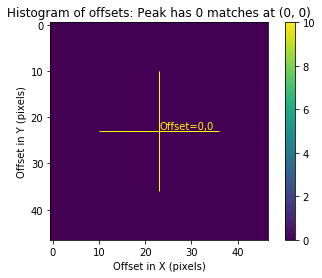

In [6]:
tweakreg.TweakReg('@drz.list', 
                  imagefindcfg={'threshold': 10, 'conv_width': 4.5, 'peakmin': 1}, 
                  minobj=5, 
                  shiftfile=True, 
                  expand_refcat=True, 
                  enforce_user_order=True, 
                  outshifts='shift4_drc.txt',
                  searchrad=3.0,
                  ylimit=0.5, 
                  updatehdr=True, 
                  interactive=False)

Tweakback is then run on the aligned DRZ files to propogate the updated WCS information back to the FLT files.

In [7]:
drz_files = glob.glob('i*_drz.fits')

for f in drz_files:
    tweakback.tweakback(f, verbose=True)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



INFO:drizzlepac.updatehdr:    with WCS of


TweakBack Version 0.4.0(14-Oct-2014) started at: 15:04:37.828 (10/05/2019)


....Updating header for ibxl50clq_flt.fits...


Processing ibxl50clq_flt.fits['SCI',1]

Updating header for ibxl50clq_flt.fits[1]
WCS Keywords

CD_11  CD_12: 3.7140948061587e-05 5.471334066042894e-06
CD_21  CD_22: 6.001383892880336e-06 -3.315572923462659e-05
CRVAL    : 85.29350621696 -2.4784269014740063
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13544167579742653
ORIENTAT : 170.62954036293192
WCSNAME  :  TWEAK


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



INFO:drizzlepac.updatehdr:    with WCS of



....Updating header for ibxl50cqq_flt.fits...


Processing ibxl50cqq_flt.fits['SCI',1]

Updating header for ibxl50cqq_flt.fits[1]
WCS Keywords

CD_11  CD_12: 3.7139799201269736e-05 5.471164832111693e-06
CD_21  CD_22: 6.001198279653945e-06 -3.31547036629626e-05
CRVAL    : 85.29318153546 -2.4764533830209796
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13543748627794666
ORIENTAT : 170.6295403542664
WCSNAME  :  TWEAK
TweakBack Version 0.4.0(14-Oct-2014) started at: 15:04:38.175 (10/05/2019)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



INFO:drizzlepac.updatehdr:    with WCS of


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



INFO:drizzlepac.updatehdr:    with WCS of



....Updating header for ibxl58sqq_flt.fits...


Processing ibxl58sqq_flt.fits['SCI',1]

Updating header for ibxl58sqq_flt.fits[1]
WCS Keywords

CD_11  CD_12: 3.663218351526359e-05 7.768857212531946e-06
CD_21  CD_22: 8.575373176746486e-06 -3.2693616744295825e-05
CRVAL    : 85.21418967191 -2.4322958236149947
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.135441066385391
ORIENTAT : 166.63294157958828
WCSNAME  :  TWEAK

....Updating header for ibxl58svq_flt.fits...


Processing ibxl58svq_flt.fits['SCI',1]

Updating header for ibxl58svq_flt.fits[1]
WCS Keywords

CD_11  CD_12: 3.663099016840775e-05 7.768604138249417e-06
CD_21  CD_22: 8.575093823040854e-06 -3.269255171278811e-05
CRVAL    : 85.2137281183 -2.4303497126669935
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13543665421419215
ORIENTAT : 166.63294157126128
WCSNAME  :  TWEAK


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



INFO:drizzlepac.updatehdr:    with WCS of


TweakBack Version 0.4.0(14-Oct-2014) started at: 15:04:38.519 (10/05/2019)


....Updating header for ibxl56huq_flt.fits...


Processing ibxl56huq_flt.fits['SCI',1]

Updating header for ibxl56huq_flt.fits[1]
WCS Keywords

CD_11  CD_12: 3.594351684927596e-05 1.0031834596239149e-05
CD_21  CD_22: 1.1111287277799828e-05 -3.2070932539207194e-05
CRVAL    : 85.27852554101 -2.4146727186250017
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13543834954833228
ORIENTAT : 162.6302408968656
WCSNAME  :  TWEAK


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



INFO:drizzlepac.updatehdr:    with WCS of



....Updating header for ibxl56i2q_flt.fits...


Processing ibxl56i2q_flt.fits['SCI',1]

Updating header for ibxl56i2q_flt.fits[1]
WCS Keywords

CD_11  CD_12: 3.5944617951243344e-05 1.0032141916714115e-05
CD_21  CD_22: 1.1111627681364144e-05 -3.2071914994251785e-05
CRVAL    : 85.27792915231 -2.4127635440499966
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.1354424986080716
ORIENTAT : 162.63024088531145
WCSNAME  :  TWEAK
TweakBack Version 0.4.0(14-Oct-2014) started at: 15:04:38.89 (10/05/2019)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



INFO:drizzlepac.updatehdr:    with WCS of



....Updating header for ibxl53kxq_flt.fits...


Processing ibxl53kxq_flt.fits['SCI',1]

Updating header for ibxl53kxq_flt.fits[1]
WCS Keywords

CD_11  CD_12: 3.6475835150628726e-05 8.339881232995077e-06
CD_21  CD_22: 9.215209852663264e-06 -3.25520568349467e-05
CRVAL    : 85.28803787252 -2.4454568293009884
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.1354388057058682
ORIENTAT : 165.62983648996172
WCSNAME  :  TWEAK

....Updating header for ibxl53l9q_flt.fits...


Processing ibxl53l9q_flt.fits['SCI',1]



WARNING

: AstropyDeprecationWarning: 
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



INFO:drizzlepac.updatehdr:    with WCS of


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Updating header for ibxl53l9q_flt.fits[1]
WCS Keywords

CD_11  CD_12: 3.64766467260059e-05 8.340066791732579e-06
CD_21  CD_22: 9.215414889396627e-06 -3.255278111066483e-05
CRVAL    : 85.28754228271 -2.4435190891080034
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13544181915540476
ORIENTAT : 165.6298364927473
WCSNAME  :  TWEAK
TweakBack Version 0.4.0(14-Oct-2014) started at: 15:04:39.354 (10/05/2019)


....Updating header for ibxl54bgq_flt.fits...



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



INFO:drizzlepac.updatehdr:    with WCS of


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



INFO:drizzlepac.updatehdr:    with WCS of



Processing ibxl54bgq_flt.fits['SCI',1]

Updating header for ibxl54bgq_flt.fits[1]
WCS Keywords

CD_11  CD_12: 3.663238802537673e-05 7.769925135730103e-06
CD_21  CD_22: 8.576568132671791e-06 -3.2693795858099766e-05
CRVAL    : 85.25468747676 -2.453970271207988
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.135442763841364
ORIENTAT : 166.6312406926125
WCSNAME  :  TWEAK

....Updating header for ibxl54blq_flt.fits...


Processing ibxl54blq_flt.fits['SCI',1]

Updating header for ibxl54blq_flt.fits[1]
WCS Keywords

CD_11  CD_12: 3.663133380554592e-05 7.769701534485498e-06
CD_21  CD_22: 8.576321308878267e-06 -3.26928549973779e-05
CRVAL    : 85.25422585692 -2.4520241731970014
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.1354388660218255
ORIENTAT : 166.63124069038366
WCSNAME  :  TWEAK


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



INFO:drizzlepac.updatehdr:    with WCS of


TweakBack Version 0.4.0(14-Oct-2014) started at: 15:04:39.777 (10/05/2019)


....Updating header for ibxl57adq_flt.fits...


Processing ibxl57adq_flt.fits['SCI',1]

Updating header for ibxl57adq_flt.fits[1]
WCS Keywords

CD_11  CD_12: 3.663208320374271e-05 7.769681063947305e-06
CD_21  CD_22: 8.576295892301033e-06 -3.2693524399547413e-05
CRVAL    : 85.247666377 -2.424370075772994
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13544147200217774
ORIENTAT : 166.63153854669932
WCSNAME  :  TWEAK


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



INFO:drizzlepac.updatehdr:    with WCS of



....Updating header for ibxl57aiq_flt.fits...


Processing ibxl57aiq_flt.fits['SCI',1]

Updating header for ibxl57aiq_flt.fits[1]
WCS Keywords

CD_11  CD_12: 3.663092866214907e-05 7.76943619069086e-06
CD_21  CD_22: 8.576025586893636e-06 -3.269249398084146e-05
CRVAL    : 85.24720477766 -2.422423976168996
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13543720321385494
ORIENTAT : 166.63153853376446
WCSNAME  :  TWEAK
TweakBack Version 0.4.0(14-Oct-2014) started at: 15:04:40.153 (10/05/2019)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



INFO:drizzlepac.updatehdr:    with WCS of



....Updating header for ibxl52k0q_flt.fits...


Processing ibxl52k0q_flt.fits['SCI',1]

Updating header for ibxl52k0q_flt.fits[1]
WCS Keywords

CD_11  CD_12: 3.663265871502757e-05 7.769320452115735e-06
CD_21  CD_22: 8.5758902217714e-06 -3.269403967172739e-05
CRVAL    : 85.22823078009 -2.4914965247999943
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.1354431563883509
ORIENTAT : 166.63233986022095
WCSNAME  :  TWEAK

....Updating header for ibxl52k5q_flt.fits...



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



INFO:drizzlepac.updatehdr:    with WCS of


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.




Processing ibxl52k5q_flt.fits['SCI',1]

Updating header for ibxl52k5q_flt.fits[1]
WCS Keywords

CD_11  CD_12: 3.663157431809724e-05 7.769090470297293e-06
CD_21  CD_22: 8.575636368221348e-06 -3.269307185269977e-05
CRVAL    : 85.22776918631 -2.489550418509003
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13543914696758064
ORIENTAT : 166.6323398469543
WCSNAME  :  TWEAK
TweakBack Version 0.4.0(14-Oct-2014) started at: 15:04:40.555 (10/05/2019)


....Updating header for ibxl55f0q_flt.fits...



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



INFO:drizzlepac.updatehdr:    with WCS of


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



INFO:drizzlepac.updatehdr:    with WCS of



Processing ibxl55f0q_flt.fits['SCI',1]

Updating header for ibxl55f0q_flt.fits[1]
WCS Keywords

CD_11  CD_12: 3.6632575428688325e-05 7.769119146832252e-06
CD_21  CD_22: 8.57566511897004e-06 -3.269396594516233e-05
CRVAL    : 85.2212100733 -2.461896192327004
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13544267969946444
ORIENTAT : 166.6326447256158
WCSNAME  :  TWEAK

....Updating header for ibxl55f5q_flt.fits...


Processing ibxl55f5q_flt.fits['SCI',1]

Updating header for ibxl55f5q_flt.fits[1]
WCS Keywords

CD_11  CD_12: 3.6631523917869384e-05 7.768896148884518e-06
CD_21  CD_22: 8.575418976233775e-06 -3.269302746678693e-05
CRVAL    : 85.22074849954 -2.4599500828819876
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.1354387918949453
ORIENTAT : 166.63264470212326
WCSNAME  :  TWEAK


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



INFO:drizzlepac.updatehdr:    with WCS of


TweakBack Version 0.4.0(14-Oct-2014) started at: 15:04:40.939 (10/05/2019)


....Updating header for ibxl51eoq_flt.fits...


Processing ibxl51eoq_flt.fits['SCI',1]

Updating header for ibxl51eoq_flt.fits[1]
WCS Keywords

CD_11  CD_12: 3.663248710314778e-05 7.770125582381539e-06
CD_21  CD_22: 8.57679221390603e-06 -3.2693883686494416e-05
CRVAL    : 85.26170888723 -2.4835704290249945
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.1354432950174527
ORIENTAT : 166.63094281607843
WCSNAME  :  TWEAK


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



INFO:drizzlepac.updatehdr:    with WCS of



....Updating header for ibxl51etq_flt.fits...


Processing ibxl51etq_flt.fits['SCI',1]

Updating header for ibxl51etq_flt.fits[1]
WCS Keywords

CD_11  CD_12: 3.663138742711097e-05 7.769892322935907e-06
CD_21  CD_22: 8.576534754971775e-06 -3.26929022174014e-05
CRVAL    : 85.26124724703 -2.4816243342580013
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.1354392291537339
ORIENTAT : 166.63094281704633
WCSNAME  :  TWEAK


## 3. Compare  `skymethod` options in AstroDrizzle

### `skymethod = 'localmin'`

When using AstroDrizzle to compute the sky in each frame, 'localmin' will compute a common sky for all members of an exposure, as described [here](https://drizzlepac.readthedocs.io/en/deployment/sky.html#drizzlepac.sky.sky). This algorithm is recommended when images are dominated by blank sky instead of extended, diffuse sources.

For a typical use, it will compute sky values for each chip/image extension (marked for sky subtraction in the input parameter) in an input image, and it will subtract the previously found minimum sky value from all chips in that image. This process is repeated for each input image.

In the command below, the aligned FLT frames are sky subtracted and drizzled together. Because the WFC3/IR data products are already cleaned of cosmic rays during calwf3 processing, cosmic-ray rejection is turned off in AstroDrizzle by setting the parameters `driz_separate`, `median`, `blot`, and `driz_cr` to 'False'.

In [8]:
drizzlepac.astrodrizzle.AstroDrizzle('*flt.fits', 
                                     output='f160w_localmin',
                                     preserve=False, 
                                     skymethod='localmin', 
                                     driz_separate=False, 
                                     median=False, 
                                     blot=False, 
                                     driz_cr=False, 
                                     final_bits='64',
                                     final_wcs=True, 
                                     final_rot=257.)

INFO:drizzlepac.util:Setting up logfile :  astrodrizzle.log


Setting up logfile :  astrodrizzle.log


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 15:04:41.404 (10/05/2019)


AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 15:04:41.404 (10/05/2019)


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:Version Information


INFO:drizzlepac.astrodrizzle:--------------------


INFO:drizzlepac.astrodrizzle:Python Version [GCC 7.3.0]


INFO:drizzlepac.astrodrizzle:3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 


INFO:drizzlepac.astrodrizzle:numpy Version -> 1.15.4 


INFO:drizzlepac.astrodrizzle:astropy Version -> 3.1.2 


INFO:drizzlepac.astrodrizzle:stwcs Version -> 1.4.2 


INFO:drizzlepac.util:==== Processing Step  Initialization  started at  15:04:41.408 (10/05/2019)


==== Processing Step  Initialization  started at  15:04:41.408 (10/05/2019)


INFO:drizzlepac.processInput:Executing serially


INFO:drizzlepac.processInput:Setting up output name: f160w_localmin_drz.fits


INFO:drizzlepac.processInput:-Creating imageObject List as input for processing steps.


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.005683985984569359


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.01014499957535011


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.01285747700708222


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.01433167415871265


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.002829942078735735


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.007051970793741115


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.002908582860835039


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.001675929379968062


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.001095350556817389


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl50clq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl50cqq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl51eoq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl51etq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl52k0q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl52k5q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl53kxq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl53l9q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl54bgq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl54blq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl55f0q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl55f5q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl56huq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl56i2q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl57adq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl57aiq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl58sqq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl58svq_flt.fits[DQ,1]


INFO:drizzlepac.processInput:-Creating output WCS.


INFO:astropy.wcs.wcs:WCS Keywords


WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 85.25348306518585  -2.4518020585456224  


CRVAL : 85.25348306518585  -2.4518020585456224  


INFO:astropy.wcs.wcs:CRPIX : 1620.251719630333  1672.744352276096  


CRPIX : 1620.251719630333  1672.744352276096  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : 8.013881489775232e-06  -3.4711934332333745e-05  


CD1_1 CD1_2  : 8.013881489775232e-06  -3.4711934332333745e-05  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : -3.4711934332333745e-05  -8.013881489775232e-06  


CD2_1 CD2_2  : -3.4711934332333745e-05  -8.013881489775232e-06  


INFO:astropy.wcs.wcs:NAXIS : 3241  3344


NAXIS : 3241  3344


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:*  Estimated memory usage:  up to 131 Mb.


*  Estimated memory usage:  up to 131 Mb.


INFO:drizzlepac.processInput:*  Output image size:       3241 X 3344 pixels. 


*  Output image size:       3241 X 3344 pixels. 


INFO:drizzlepac.processInput:*  Output image file:       ~ 124 Mb. 


*  Output image file:       ~ 124 Mb. 


INFO:drizzlepac.processInput:*  Cores available:         1


*  Cores available:         1


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.util:==== Processing Step  Initialization  finished at  15:04:45.877 (10/05/2019)


==== Processing Step  Initialization  finished at  15:04:45.877 (10/05/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.astrodrizzle:USER INPUT PARAMETERS common to all Processing Steps:


INFO:drizzlepac.astrodrizzle:	build :	False


INFO:drizzlepac.astrodrizzle:	coeffs :	True


INFO:drizzlepac.astrodrizzle:	context :	True


INFO:drizzlepac.astrodrizzle:	crbit :	4096


INFO:drizzlepac.astrodrizzle:	group :	


INFO:drizzlepac.astrodrizzle:	in_memory :	False


INFO:drizzlepac.astrodrizzle:	input :	*flt.fits


INFO:drizzlepac.astrodrizzle:	mdriztab :	False


INFO:drizzlepac.astrodrizzle:	num_cores :	None


INFO:drizzlepac.astrodrizzle:	output :	f160w_localmin


INFO:drizzlepac.astrodrizzle:	proc_unit :	native


INFO:drizzlepac.astrodrizzle:	resetbits :	4096


INFO:drizzlepac.astrodrizzle:	runfile :	astrodrizzle.log


INFO:drizzlepac.astrodrizzle:	stepsize :	10


INFO:drizzlepac.astrodrizzle:	updatewcs :	False


INFO:drizzlepac.astrodrizzle:	wcskey :	


INFO:drizzlepac.util:==== Processing Step  Static Mask  started at  15:04:45.887 (10/05/2019)


==== Processing Step  Static Mask  started at  15:04:45.887 (10/05/2019)


INFO:drizzlepac.staticMask:USER INPUT PARAMETERS for Static Mask Step:


INFO:drizzlepac.staticMask:	static :	True


INFO:drizzlepac.staticMask:	static_sig :	4.0


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.209246;   rms = 0.216049;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.197809;   rms = 0.195324;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.218648;   rms = 0.206520;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.218050;   rms = 0.199655;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.776681;   rms = 0.199609;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.763172;   rms = 0.203367;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.185151;   rms = 0.091467;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.171142;   rms = 0.095910;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.173319;   rms = 0.110799;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.165512;   rms = 0.110564;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.791136;   rms = 0.313897;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.802448;   rms = 0.299563;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.316591;   rms = 0.191670;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.303690;   rms = 0.199028;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.136212;   rms = 0.212368;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.146377;   rms = 0.221635;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.778128;   rms = 0.213945;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.774430;   rms = 0.194110;   static_sig = 4.00


INFO:drizzlepac.staticMask:Saving static mask to disk: ./WFC3IR_1014x1014_1_staticMask.fits


INFO:drizzlepac.util:==== Processing Step  Static Mask  finished at  15:04:46.85 (10/05/2019)


==== Processing Step  Static Mask  finished at  15:04:46.85 (10/05/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Subtract Sky  started at  15:04:46.856 (10/05/2019)


==== Processing Step  Subtract Sky  started at  15:04:46.856 (10/05/2019)


INFO:drizzlepac.sky:USER INPUT PARAMETERS for Sky Subtraction Step:


INFO:drizzlepac.sky:	sky_bits :	0


INFO:drizzlepac.sky:	skyclip :	5


INFO:drizzlepac.sky:	skyfile :	


INFO:drizzlepac.sky:	skylower :	None

INFO:drizzlepac.sky:	skylsigma :	4.0


INFO:drizzlepac.sky:	skymask_cat :	

INFO:drizzlepac.sky:	skymethod :	localmin


INFO:drizzlepac.sky:	skystat :	median


INFO:drizzlepac.sky:	skysub :	True


INFO:drizzlepac.sky:	skyupper :	None


INFO:drizzlepac.sky:	skyuser :	


INFO:drizzlepac.sky:	skyusigma :	4.0


INFO:drizzlepac.sky:	skywidth :	0.1


INFO:drizzlepac.sky:	use_static :	True


INFO:stsci.skypac.utils:***** skymatch started on 2019-05-10 15:04:47.344400


***** skymatch started on 2019-05-10 15:04:47.344400


INFO:stsci.skypac.utils:      Version 1.0.2 (2019-03-07 00:54:44 -0500)


      Version 1.0.2 (2019-03-07 00:54:44 -0500)


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:'skymatch' task will apply computed sky differences to input image file(s).


'skymatch' task will apply computed sky differences to input image file(s).


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


INFO:stsci.skypac.utils:'MDRIZSKY' header keyword will represent sky value *computed* from data.


'MDRIZSKY' header keyword will represent sky value *computed* from data.


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  User specified keywords:  -----


-----  User specified keywords:  -----


INFO:stsci.skypac.utils:       Sky Value Keyword:  'MDRIZSKY'


       Sky Value Keyword:  'MDRIZSKY'


INFO:stsci.skypac.utils:       Data Units Keyword: 'BUNIT'


       Data Units Keyword: 'BUNIT'


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Input file list:  -----


-----  Input file list:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl50clq_flt.fits'


   **  Input image: 'ibxl50clq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl50clq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl50clq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl50cqq_flt.fits'


   **  Input image: 'ibxl50cqq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl50cqq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl50cqq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl51eoq_flt.fits'


   **  Input image: 'ibxl51eoq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl51eoq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl51eoq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl51etq_flt.fits'


   **  Input image: 'ibxl51etq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl51etq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl51etq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl52k0q_flt.fits'


   **  Input image: 'ibxl52k0q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl52k0q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl52k0q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl52k5q_flt.fits'


   **  Input image: 'ibxl52k5q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl52k5q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl52k5q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl53kxq_flt.fits'


   **  Input image: 'ibxl53kxq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl53kxq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl53kxq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl53l9q_flt.fits'


   **  Input image: 'ibxl53l9q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl53l9q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl53l9q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl54bgq_flt.fits'


   **  Input image: 'ibxl54bgq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl54bgq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl54bgq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl54blq_flt.fits'


   **  Input image: 'ibxl54blq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl54blq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl54blq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl55f0q_flt.fits'


   **  Input image: 'ibxl55f0q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl55f0q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl55f0q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl55f5q_flt.fits'


   **  Input image: 'ibxl55f5q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl55f5q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl55f5q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl56huq_flt.fits'


   **  Input image: 'ibxl56huq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl56huq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl56huq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl56i2q_flt.fits'


   **  Input image: 'ibxl56i2q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl56i2q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl56i2q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl57adq_flt.fits'


   **  Input image: 'ibxl57adq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl57adq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl57adq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl57aiq_flt.fits'


   **  Input image: 'ibxl57aiq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl57aiq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl57aiq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl58sqq_flt.fits'


   **  Input image: 'ibxl58sqq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl58sqq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl58sqq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl58svq_flt.fits'


   **  Input image: 'ibxl58svq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl58svq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl58svq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Sky statistics parameters:  -----


-----  Sky statistics parameters:  -----


INFO:stsci.skypac.utils:       statistics function: 'median'


       statistics function: 'median'


INFO:stsci.skypac.utils:       lower = None


       lower = None


INFO:stsci.skypac.utils:       upper = None


       upper = None


INFO:stsci.skypac.utils:       nclip = 5


       nclip = 5


INFO:stsci.skypac.utils:       lsigma = 4.0


       lsigma = 4.0


INFO:stsci.skypac.utils:       usigma = 4.0


       usigma = 4.0


INFO:stsci.skypac.utils:       binwidth = 0.1


       binwidth = 0.1


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Data->Brightness conversion parameters for input files:  -----


-----  Data->Brightness conversion parameters for input files:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl50clq_flt.fits


   *   Image: ibxl50clq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl50cqq_flt.fits


   *   Image: ibxl50cqq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl51eoq_flt.fits


   *   Image: ibxl51eoq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl51etq_flt.fits


   *   Image: ibxl51etq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl52k0q_flt.fits


   *   Image: ibxl52k0q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl52k5q_flt.fits


   *   Image: ibxl52k5q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl53kxq_flt.fits


   *   Image: ibxl53kxq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl53l9q_flt.fits


   *   Image: ibxl53l9q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl54bgq_flt.fits


   *   Image: ibxl54bgq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl54blq_flt.fits


   *   Image: ibxl54blq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl55f0q_flt.fits


   *   Image: ibxl55f0q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl55f5q_flt.fits


   *   Image: ibxl55f5q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl56huq_flt.fits


   *   Image: ibxl56huq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl56i2q_flt.fits


   *   Image: ibxl56i2q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl57adq_flt.fits


   *   Image: ibxl57adq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl57aiq_flt.fits


   *   Image: ibxl57aiq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl58sqq_flt.fits


   *   Image: ibxl58sqq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl58svq_flt.fits


   *   Image: ibxl58svq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Computing sky values requested image extensions (detector chips):  -----


-----  Computing sky values requested image extensions (detector chips):  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image:   'ibxl50clq_flt.fits['SCI',1]'  --  SKY = 69.93720780657819 (brightness units)


   *   Image:   'ibxl50clq_flt.fits['SCI',1]'  --  SKY = 69.93720780657819 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.15033   NEW MDRIZSKY = 1.15033


      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.15033   NEW MDRIZSKY = 1.15033


INFO:stsci.skypac.utils:   *   Image:   'ibxl50cqq_flt.fits['SCI',1]'  --  SKY = 70.67867543070503 (brightness units)


   *   Image:   'ibxl50cqq_flt.fits['SCI',1]'  --  SKY = 70.67867543070503 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.16253   NEW MDRIZSKY = 1.16253


      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.16253   NEW MDRIZSKY = 1.16253


INFO:stsci.skypac.utils:   *   Image:   'ibxl51eoq_flt.fits['SCI',1]'  --  SKY = 71.36475675324762 (brightness units)


   *   Image:   'ibxl51eoq_flt.fits['SCI',1]'  --  SKY = 71.36475675324762 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.17381   NEW MDRIZSKY = 1.17381


      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.17381   NEW MDRIZSKY = 1.17381


INFO:stsci.skypac.utils:   *   Image:   'ibxl51etq_flt.fits['SCI',1]'  --  SKY = 71.18530571592413 (brightness units)


   *   Image:   'ibxl51etq_flt.fits['SCI',1]'  --  SKY = 71.18530571592413 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.17086   NEW MDRIZSKY = 1.17086


      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.17086   NEW MDRIZSKY = 1.17086


INFO:stsci.skypac.utils:   *   Image:   'ibxl52k0q_flt.fits['SCI',1]'  --  SKY = 48.73227741363333 (brightness units)


   *   Image:   'ibxl52k0q_flt.fits['SCI',1]'  --  SKY = 48.73227741363333 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.801552   NEW MDRIZSKY = 0.801552


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.801552   NEW MDRIZSKY = 0.801552


INFO:stsci.skypac.utils:   *   Image:   'ibxl52k5q_flt.fits['SCI',1]'  --  SKY = 48.418694698291006 (brightness units)


   *   Image:   'ibxl52k5q_flt.fits['SCI',1]'  --  SKY = 48.418694698291006 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796394   NEW MDRIZSKY = 0.796394


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796394   NEW MDRIZSKY = 0.796394


INFO:stsci.skypac.utils:   *   Image:   'ibxl53kxq_flt.fits['SCI',1]'  --  SKY = 73.115462519472 (brightness units)


   *   Image:   'ibxl53kxq_flt.fits['SCI',1]'  --  SKY = 73.115462519472 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.20261   NEW MDRIZSKY = 1.20261


      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.20261   NEW MDRIZSKY = 1.20261


INFO:stsci.skypac.utils:   *   Image:   'ibxl53l9q_flt.fits['SCI',1]'  --  SKY = 71.96664249014454 (brightness units)


   *   Image:   'ibxl53l9q_flt.fits['SCI',1]'  --  SKY = 71.96664249014454 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.18371   NEW MDRIZSKY = 1.18371


      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.18371   NEW MDRIZSKY = 1.18371


INFO:stsci.skypac.utils:   *   Image:   'ibxl54bgq_flt.fits['SCI',1]'  --  SKY = 71.13055720477946 (brightness units)


   *   Image:   'ibxl54bgq_flt.fits['SCI',1]'  --  SKY = 71.13055720477946 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.16996   NEW MDRIZSKY = 1.16996


      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.16996   NEW MDRIZSKY = 1.16996


INFO:stsci.skypac.utils:   *   Image:   'ibxl54blq_flt.fits['SCI',1]'  --  SKY = 70.73079305628634 (brightness units)


   *   Image:   'ibxl54blq_flt.fits['SCI',1]'  --  SKY = 70.73079305628634 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.16338   NEW MDRIZSKY = 1.16338


      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.16338   NEW MDRIZSKY = 1.16338


INFO:stsci.skypac.utils:   *   Image:   'ibxl55f0q_flt.fits['SCI',1]'  --  SKY = 61.205298621834984 (brightness units)


   *   Image:   'ibxl55f0q_flt.fits['SCI',1]'  --  SKY = 61.205298621834984 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.00671   NEW MDRIZSKY = 1.00671


      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.00671   NEW MDRIZSKY = 1.00671


INFO:stsci.skypac.utils:   *   Image:   'ibxl55f5q_flt.fits['SCI',1]'  --  SKY = 61.379973478480125 (brightness units)


   *   Image:   'ibxl55f5q_flt.fits['SCI',1]'  --  SKY = 61.379973478480125 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.00958   NEW MDRIZSKY = 1.00958


      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.00958   NEW MDRIZSKY = 1.00958


INFO:stsci.skypac.utils:   *   Image:   'ibxl56huq_flt.fits['SCI',1]'  --  SKY = 82.88270852100587 (brightness units)


   *   Image:   'ibxl56huq_flt.fits['SCI',1]'  --  SKY = 82.88270852100587 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.36326   NEW MDRIZSKY = 1.36326


      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.36326   NEW MDRIZSKY = 1.36326


INFO:stsci.skypac.utils:   *   Image:   'ibxl56i2q_flt.fits['SCI',1]'  --  SKY = 82.80364424935149 (brightness units)


   *   Image:   'ibxl56i2q_flt.fits['SCI',1]'  --  SKY = 82.80364424935149 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.36196   NEW MDRIZSKY = 1.36196


      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.36196   NEW MDRIZSKY = 1.36196


INFO:stsci.skypac.utils:   *   Image:   'ibxl57adq_flt.fits['SCI',1]'  --  SKY = 68.88099060050929 (brightness units)


   *   Image:   'ibxl57adq_flt.fits['SCI',1]'  --  SKY = 68.88099060050929 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.13296   NEW MDRIZSKY = 1.13296


      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.13296   NEW MDRIZSKY = 1.13296


INFO:stsci.skypac.utils:   *   Image:   'ibxl57aiq_flt.fits['SCI',1]'  --  SKY = 68.0795126941111 (brightness units)


   *   Image:   'ibxl57aiq_flt.fits['SCI',1]'  --  SKY = 68.0795126941111 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.11978   NEW MDRIZSKY = 1.11978


      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.11978   NEW MDRIZSKY = 1.11978


INFO:stsci.skypac.utils:   *   Image:   'ibxl58sqq_flt.fits['SCI',1]'  --  SKY = 48.9500719773284 (brightness units)


   *   Image:   'ibxl58sqq_flt.fits['SCI',1]'  --  SKY = 48.9500719773284 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.805134   NEW MDRIZSKY = 0.805134


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.805134   NEW MDRIZSKY = 0.805134


INFO:stsci.skypac.utils:   *   Image:   'ibxl58svq_flt.fits['SCI',1]'  --  SKY = 48.60946651591739 (brightness units)


   *   Image:   'ibxl58svq_flt.fits['SCI',1]'  --  SKY = 48.60946651591739 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.799532   NEW MDRIZSKY = 0.799532


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.799532   NEW MDRIZSKY = 0.799532


INFO:stsci.skypac.utils:***** skymatch ended on 2019-05-10 15:04:49.461003


***** skymatch ended on 2019-05-10 15:04:49.461003


INFO:stsci.skypac.utils:TOTAL RUN TIME: 0:00:02.116603


TOTAL RUN TIME: 0:00:02.116603


INFO:drizzlepac.util:==== Processing Step  Subtract Sky  finished at  15:04:49.859 (10/05/2019)


==== Processing Step  Subtract Sky  finished at  15:04:49.859 (10/05/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  started at  15:04:49.861 (10/05/2019)


==== Processing Step  Separate Drizzle  started at  15:04:49.861 (10/05/2019)


INFO:drizzlepac.adrizzle:Single drizzle step not performed.


INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  finished at  15:04:49.863 (10/05/2019)


==== Processing Step  Separate Drizzle  finished at  15:04:49.863 (10/05/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Create Median  started at  15:04:49.865 (10/05/2019)


==== Processing Step  Create Median  started at  15:04:49.865 (10/05/2019)


INFO:drizzlepac.createMedian:Median combination step not performed.


INFO:drizzlepac.util:==== Processing Step  Blot  started at  15:04:49.867 (10/05/2019)


==== Processing Step  Blot  started at  15:04:49.867 (10/05/2019)


INFO:drizzlepac.ablot:Blot step not performed.


INFO:drizzlepac.util:==== Processing Step  Blot  finished at  15:04:49.869 (10/05/2019)


==== Processing Step  Blot  finished at  15:04:49.869 (10/05/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Driz_CR  started at  15:04:49.87 (10/05/2019)


==== Processing Step  Driz_CR  started at  15:04:49.87 (10/05/2019)


INFO:drizzlepac.drizCR:Cosmic-ray identification (driz_cr) step not performed.


INFO:drizzlepac.util:==== Processing Step  Final Drizzle  started at  15:04:49.872 (10/05/2019)


==== Processing Step  Final Drizzle  started at  15:04:49.872 (10/05/2019)


INFO:drizzlepac.adrizzle:Interpreted paramDict with single=False as:
{'build': False, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'wht_type': 'EXP', 'kernel': 'square', 'wt_scl': 'exptime', 'pixfrac': 1.0, 'fillval': None, 'maskval': None, 'bits': 64, 'units': 'cps'}


INFO:drizzlepac.adrizzle:USER INPUT PARAMETERS for Final Drizzle Step:


INFO:drizzlepac.adrizzle:	bits :	64


INFO:drizzlepac.adrizzle:	build :	False


INFO:drizzlepac.adrizzle:	clean :	False


INFO:drizzlepac.adrizzle:	coeffs :	True


INFO:drizzlepac.adrizzle:	crbit :	4096


INFO:drizzlepac.adrizzle:	fillval :	None


INFO:drizzlepac.adrizzle:	kernel :	square


INFO:drizzlepac.adrizzle:	maskval :	None


INFO:drizzlepac.adrizzle:	pixfrac :	1.0


INFO:drizzlepac.adrizzle:	proc_unit :	native


INFO:drizzlepac.adrizzle:	stepsize :	10


INFO:drizzlepac.adrizzle:	units :	cps


INFO:drizzlepac.adrizzle:	wcskey :	


INFO:drizzlepac.adrizzle:	wht_type :	EXP


INFO:drizzlepac.adrizzle:	wt_scl :	exptime


INFO:drizzlepac.adrizzle:  **Using sub-sampling value of 10 for kernel square


INFO:drizzlepac.adrizzle:Running Drizzle to create output frame with WCS of: 


INFO:astropy.wcs.wcs:WCS Keywords


WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 85.25348306518585  -2.4518020585456224  


CRVAL : 85.25348306518585  -2.4518020585456224  


INFO:astropy.wcs.wcs:CRPIX : 1620.251719630333  1672.744352276096  


CRPIX : 1620.251719630333  1672.744352276096  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : 8.013881489775232e-06  -3.4711934332333745e-05  


CD1_1 CD1_2  : 8.013881489775232e-06  -3.4711934332333745e-05  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : -3.4711934332333745e-05  -8.013881489775232e-06  


CD2_1 CD2_2  : -3.4711934332333745e-05  -8.013881489775232e-06  


INFO:astropy.wcs.wcs:NAXIS : 3241  3344


NAXIS : 3241  3344


INFO:drizzlepac.adrizzle:-Drizzle input: ibxl50clq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 1.150332 to ibxl50clq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl50clq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl50cqq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 1.162527 to ibxl50cqq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl50cqq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl51eoq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 1.173812 to ibxl51eoq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl51eoq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl51etq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 1.170860 to ibxl51etq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl51etq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl52k0q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.801552 to ibxl52k0q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl52k0q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl52k5q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.796394 to ibxl52k5q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl52k5q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl53kxq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 1.202608 to ibxl53kxq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl53kxq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl53l9q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 1.183712 to ibxl53l9q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl53l9q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl54bgq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 1.169960 to ibxl54bgq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl54bgq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl54blq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 1.163385 to ibxl54blq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl54blq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl55f0q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 1.006709 to ibxl55f0q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl55f0q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl55f5q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 1.009582 to ibxl55f5q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl55f5q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl56huq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 1.363260 to ibxl56huq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl56huq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl56i2q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 1.361960 to ibxl56i2q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl56i2q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl57adq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 1.132959 to ibxl57adq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl57adq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl57aiq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 1.119776 to ibxl57aiq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl57aiq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl58sqq_flt.fits[sci,1]

INFO:drizzlepac.adrizzle:Applying sky value of 0.805134 to ibxl58sqq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl58sqq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl58svq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.799532 to ibxl58svq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl58svq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.outputimage:-Generating simple FITS output: f160w_localmin_drz_sci.fits


-Generating simple FITS output: f160w_localmin_drz_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: f160w_localmin_drz_sci.fits


Writing out image to disk: f160w_localmin_drz_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: f160w_localmin_drz_wht.fits


Writing out image to disk: f160w_localmin_drz_wht.fits


INFO:drizzlepac.outputimage:Writing out image to disk: f160w_localmin_drz_ctx.fits


Writing out image to disk: f160w_localmin_drz_ctx.fits


INFO:drizzlepac.util:==== Processing Step  Final Drizzle  finished at  15:05:01.409 (10/05/2019)


==== Processing Step  Final Drizzle  finished at  15:05:01.409 (10/05/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 2.2.6 is finished processing at 15:05:01.413 (10/05/2019).


AstroDrizzle Version 2.2.6 is finished processing at 15:05:01.413 (10/05/2019).


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.util:


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:                   Step          Elapsed time


                   Step          Elapsed time


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:


INFO:drizzlepac.util:         Initialization          4.4690 sec.


         Initialization          4.4690 sec.


INFO:drizzlepac.util:            Static Mask          0.9666 sec.


            Static Mask          0.9666 sec.


INFO:drizzlepac.util:           Subtract Sky          3.0027 sec.


           Subtract Sky          3.0027 sec.


INFO:drizzlepac.util:       Separate Drizzle          0.0018 sec.


       Separate Drizzle          0.0018 sec.


INFO:drizzlepac.util:          Create Median          0.0000 sec.


          Create Median          0.0000 sec.


INFO:drizzlepac.util:                   Blot          0.0022 sec.


                   Blot          0.0022 sec.


INFO:drizzlepac.util:                Driz_CR          0.0000 sec.


                Driz_CR          0.0000 sec.


INFO:drizzlepac.util:          Final Drizzle          11.5363 sec.


          Final Drizzle          11.5363 sec.


INFO:drizzlepac.util:   ====================          ====================


   ====================          ====================


INFO:drizzlepac.util:                  Total          19.9788 sec.


                  Total          19.9788 sec.


INFO:drizzlepac.util:Trailer file written to:  astrodrizzle.log


Trailer file written to:  astrodrizzle.log


### `skymethod = 'match'`

When `skymethod` is set to ‘match’, differences in sky values between images in common sky regions will be computed. Thus, sky values will be relative (delta) to the sky computed in one of the input images whose sky value will be set to and reported as 0. This setting “equalizes” sky values between the images in large mosaics. 

This is the **recommended** setting for images containing diffuse sources (e.g., galaxies, nebulae) covering significant parts of the image.

In [9]:
drizzlepac.astrodrizzle.AstroDrizzle('*flt.fits', 
                                     output='f160w_match',
                                     preserve=False, 
                                     skymethod='match',
                                     driz_separate=False, 
                                     median=False, 
                                     blot=False, 
                                     driz_cr=False, 
                                     final_bits='64',
                                     final_wcs=True, 
                                     final_rot=257.)

INFO:drizzlepac.util:Setting up logfile :  astrodrizzle.log


Setting up logfile :  astrodrizzle.log


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 15:05:01.904 (10/05/2019)


AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 15:05:01.904 (10/05/2019)


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:Version Information


INFO:drizzlepac.astrodrizzle:--------------------


INFO:drizzlepac.astrodrizzle:Python Version [GCC 7.3.0]


INFO:drizzlepac.astrodrizzle:3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 


INFO:drizzlepac.astrodrizzle:numpy Version -> 1.15.4 


INFO:drizzlepac.astrodrizzle:astropy Version -> 3.1.2 


INFO:drizzlepac.astrodrizzle:stwcs Version -> 1.4.2 


INFO:drizzlepac.util:==== Processing Step  Initialization  started at  15:05:01.909 (10/05/2019)


==== Processing Step  Initialization  started at  15:05:01.909 (10/05/2019)


INFO:drizzlepac.processInput:Executing serially


INFO:drizzlepac.processInput:Setting up output name: f160w_match_drz.fits


INFO:drizzlepac.processInput:-Creating imageObject List as input for processing steps.


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 1.150331616401672


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 1.162527322769165


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 1.173812031745911


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 1.170860409736633


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.8015515804290771


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.7963937520980835


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 1.202607750892639


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 1.183711886405945


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 1.169959902763367


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 1.163384556770325


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 1.00670862197876


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 1.009581685066223


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 1.36326003074646


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 1.36195957660675


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 1.132958889007568


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 1.119776129722595


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.8051338791847229


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.7995315790176392


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl50clq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl50cqq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl51eoq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl51etq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl52k0q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl52k5q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl53kxq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl53l9q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl54bgq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl54blq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl55f0q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl55f5q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl56huq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl56i2q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl57adq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl57aiq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl58sqq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl58svq_flt.fits[DQ,1]


INFO:drizzlepac.processInput:-Creating output WCS.


INFO:astropy.wcs.wcs:WCS Keywords


WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 85.25348306518585  -2.4518020585456224  


CRVAL : 85.25348306518585  -2.4518020585456224  


INFO:astropy.wcs.wcs:CRPIX : 1620.251719630333  1672.744352276096  


CRPIX : 1620.251719630333  1672.744352276096  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : 8.013881489775232e-06  -3.4711934332333745e-05  


CD1_1 CD1_2  : 8.013881489775232e-06  -3.4711934332333745e-05  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : -3.4711934332333745e-05  -8.013881489775232e-06  


CD2_1 CD2_2  : -3.4711934332333745e-05  -8.013881489775232e-06  


INFO:astropy.wcs.wcs:NAXIS : 3241  3344


NAXIS : 3241  3344


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:*  Estimated memory usage:  up to 131 Mb.


*  Estimated memory usage:  up to 131 Mb.


INFO:drizzlepac.processInput:*  Output image size:       3241 X 3344 pixels. 


*  Output image size:       3241 X 3344 pixels. 


INFO:drizzlepac.processInput:*  Output image file:       ~ 124 Mb. 


*  Output image file:       ~ 124 Mb. 


INFO:drizzlepac.processInput:*  Cores available:         1


*  Cores available:         1


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.util:==== Processing Step  Initialization  finished at  15:05:06.42 (10/05/2019)


==== Processing Step  Initialization  finished at  15:05:06.42 (10/05/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.astrodrizzle:USER INPUT PARAMETERS common to all Processing Steps:


INFO:drizzlepac.astrodrizzle:	build :	False


INFO:drizzlepac.astrodrizzle:	coeffs :	True


INFO:drizzlepac.astrodrizzle:	context :	True


INFO:drizzlepac.astrodrizzle:	crbit :	4096


INFO:drizzlepac.astrodrizzle:	group :	


INFO:drizzlepac.astrodrizzle:	in_memory :	False


INFO:drizzlepac.astrodrizzle:	input :	*flt.fits


INFO:drizzlepac.astrodrizzle:	mdriztab :	False


INFO:drizzlepac.astrodrizzle:	num_cores :	None


INFO:drizzlepac.astrodrizzle:	output :	f160w_match


INFO:drizzlepac.astrodrizzle:	proc_unit :	native


INFO:drizzlepac.astrodrizzle:	resetbits :	4096


INFO:drizzlepac.astrodrizzle:	runfile :	astrodrizzle.log


INFO:drizzlepac.astrodrizzle:	stepsize :	10


INFO:drizzlepac.astrodrizzle:	updatewcs :	False


INFO:drizzlepac.astrodrizzle:	wcskey :	


INFO:drizzlepac.util:==== Processing Step  Static Mask  started at  15:05:06.434 (10/05/2019)


==== Processing Step  Static Mask  started at  15:05:06.434 (10/05/2019)


INFO:drizzlepac.staticMask:USER INPUT PARAMETERS for Static Mask Step:


INFO:drizzlepac.staticMask:	static :	True


INFO:drizzlepac.staticMask:	static_sig :	4.0


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.209246;   rms = 0.216049;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.197809;   rms = 0.195324;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.218648;   rms = 0.206520;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.218050;   rms = 0.199655;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.776681;   rms = 0.199609;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.763172;   rms = 0.203367;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.185151;   rms = 0.091467;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.171142;   rms = 0.095910;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.173319;   rms = 0.110799;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.165512;   rms = 0.110564;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.791136;   rms = 0.313897;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.802448;   rms = 0.299563;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.316591;   rms = 0.191670;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.303690;   rms = 0.199028;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.136212;   rms = 0.212368;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.146377;   rms = 0.221635;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.778128;   rms = 0.213945;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.774430;   rms = 0.194110;   static_sig = 4.00


INFO:drizzlepac.staticMask:Saving static mask to disk: ./WFC3IR_1014x1014_1_staticMask.fits


INFO:drizzlepac.util:==== Processing Step  Static Mask  finished at  15:05:07.380 (10/05/2019)


==== Processing Step  Static Mask  finished at  15:05:07.380 (10/05/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Subtract Sky  started at  15:05:07.383 (10/05/2019)


==== Processing Step  Subtract Sky  started at  15:05:07.383 (10/05/2019)


INFO:drizzlepac.sky:USER INPUT PARAMETERS for Sky Subtraction Step:


INFO:drizzlepac.sky:	sky_bits :	0


INFO:drizzlepac.sky:	skyclip :	5


INFO:drizzlepac.sky:	skyfile :	


INFO:drizzlepac.sky:	skylower :	None


INFO:drizzlepac.sky:	skylsigma :	4.0


INFO:drizzlepac.sky:	skymask_cat :	


INFO:drizzlepac.sky:	skymethod :	match


INFO:drizzlepac.sky:	skystat :	median


INFO:drizzlepac.sky:	skysub :	True


INFO:drizzlepac.sky:	skyupper :	None


INFO:drizzlepac.sky:	skyuser :	


INFO:drizzlepac.sky:	skyusigma :	4.0


INFO:drizzlepac.sky:	skywidth :	0.1


INFO:drizzlepac.sky:	use_static :	True


INFO:stsci.skypac.utils:***** skymatch started on 2019-05-10 15:05:07.952166


***** skymatch started on 2019-05-10 15:05:07.952166


INFO:stsci.skypac.utils:      Version 1.0.2 (2019-03-07 00:54:44 -0500)


      Version 1.0.2 (2019-03-07 00:54:44 -0500)


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:'skymatch' task will apply computed sky differences to input image file(s).


'skymatch' task will apply computed sky differences to input image file(s).


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


INFO:stsci.skypac.utils:'MDRIZSKY' header keyword will represent sky value *computed* from data.


'MDRIZSKY' header keyword will represent sky value *computed* from data.


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  User specified keywords:  -----


-----  User specified keywords:  -----


INFO:stsci.skypac.utils:       Sky Value Keyword:  'MDRIZSKY'


       Sky Value Keyword:  'MDRIZSKY'


INFO:stsci.skypac.utils:       Data Units Keyword: 'BUNIT'


       Data Units Keyword: 'BUNIT'


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Input file list:  -----


-----  Input file list:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl50clq_flt.fits'


   **  Input image: 'ibxl50clq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl50clq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl50clq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl50cqq_flt.fits'


   **  Input image: 'ibxl50cqq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl50cqq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl50cqq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl51eoq_flt.fits'


   **  Input image: 'ibxl51eoq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl51eoq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl51eoq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl51etq_flt.fits'


   **  Input image: 'ibxl51etq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl51etq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl51etq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl52k0q_flt.fits'


   **  Input image: 'ibxl52k0q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl52k0q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl52k0q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl52k5q_flt.fits'


   **  Input image: 'ibxl52k5q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl52k5q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl52k5q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl53kxq_flt.fits'


   **  Input image: 'ibxl53kxq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl53kxq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl53kxq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl53l9q_flt.fits'


   **  Input image: 'ibxl53l9q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl53l9q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl53l9q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl54bgq_flt.fits'


   **  Input image: 'ibxl54bgq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl54bgq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl54bgq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl54blq_flt.fits'


   **  Input image: 'ibxl54blq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl54blq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl54blq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl55f0q_flt.fits'


   **  Input image: 'ibxl55f0q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl55f0q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl55f0q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl55f5q_flt.fits'


   **  Input image: 'ibxl55f5q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl55f5q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl55f5q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl56huq_flt.fits'


   **  Input image: 'ibxl56huq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl56huq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl56huq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl56i2q_flt.fits'


   **  Input image: 'ibxl56i2q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl56i2q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl56i2q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl57adq_flt.fits'


   **  Input image: 'ibxl57adq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl57adq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl57adq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl57aiq_flt.fits'


   **  Input image: 'ibxl57aiq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl57aiq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl57aiq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl58sqq_flt.fits'


   **  Input image: 'ibxl58sqq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl58sqq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl58sqq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl58svq_flt.fits'


   **  Input image: 'ibxl58svq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl58svq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl58svq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Sky statistics parameters:  -----


-----  Sky statistics parameters:  -----


INFO:stsci.skypac.utils:       statistics function: 'median'


       statistics function: 'median'


INFO:stsci.skypac.utils:       lower = None


       lower = None


INFO:stsci.skypac.utils:       upper = None


       upper = None


INFO:stsci.skypac.utils:       nclip = 5


       nclip = 5


INFO:stsci.skypac.utils:       lsigma = 4.0


       lsigma = 4.0


INFO:stsci.skypac.utils:       usigma = 4.0


       usigma = 4.0


INFO:stsci.skypac.utils:       binwidth = 0.1


       binwidth = 0.1


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Data->Brightness conversion parameters for input files:  -----


-----  Data->Brightness conversion parameters for input files:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl50clq_flt.fits


   *   Image: ibxl50clq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl50cqq_flt.fits


   *   Image: ibxl50cqq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl51eoq_flt.fits


   *   Image: ibxl51eoq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl51etq_flt.fits


   *   Image: ibxl51etq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl52k0q_flt.fits


   *   Image: ibxl52k0q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl52k5q_flt.fits


   *   Image: ibxl52k5q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl53kxq_flt.fits


   *   Image: ibxl53kxq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl53l9q_flt.fits


   *   Image: ibxl53l9q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl54bgq_flt.fits


   *   Image: ibxl54bgq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl54blq_flt.fits


   *   Image: ibxl54blq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl55f0q_flt.fits


   *   Image: ibxl55f0q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl55f5q_flt.fits


   *   Image: ibxl55f5q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl56huq_flt.fits


   *   Image: ibxl56huq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl56i2q_flt.fits


   *   Image: ibxl56i2q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl57adq_flt.fits


   *   Image: ibxl57adq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl57aiq_flt.fits


   *   Image: ibxl57aiq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl58sqq_flt.fits


   *   Image: ibxl58sqq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl58svq_flt.fits


   *   Image: ibxl58svq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Computing differences in sky values in overlapping regions:  -----


-----  Computing differences in sky values in overlapping regions:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl50clq_flt.fits['SCI',1]' SKY = 1.58399 [brightness units]


   *   Image 'ibxl50clq_flt.fits['SCI',1]' SKY = 1.58399 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0260536


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0260536


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl50cqq_flt.fits['SCI',1]' SKY = 1.36473 [brightness units]


   *   Image 'ibxl50cqq_flt.fits['SCI',1]' SKY = 1.36473 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0224471


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0224471


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl51eoq_flt.fits['SCI',1]' SKY = 2.43754 [brightness units]


   *   Image 'ibxl51eoq_flt.fits['SCI',1]' SKY = 2.43754 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0400928


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0400928


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl51etq_flt.fits['SCI',1]' SKY = 1.78844 [brightness units]


   *   Image 'ibxl51etq_flt.fits['SCI',1]' SKY = 1.78844 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0294163


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0294163


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl52k0q_flt.fits['SCI',1]' SKY = 2.19621 [brightness units]


   *   Image 'ibxl52k0q_flt.fits['SCI',1]' SKY = 2.19621 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0361235


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0361235


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl52k5q_flt.fits['SCI',1]' SKY = 1.48494 [brightness units]


   *   Image 'ibxl52k5q_flt.fits['SCI',1]' SKY = 1.48494 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0244243


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0244243


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl53kxq_flt.fits['SCI',1]' SKY = 2.61479 [brightness units]


   *   Image 'ibxl53kxq_flt.fits['SCI',1]' SKY = 2.61479 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0430082


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0430082


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl53l9q_flt.fits['SCI',1]' SKY = 1.37807 [brightness units]


   *   Image 'ibxl53l9q_flt.fits['SCI',1]' SKY = 1.37807 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0226665


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0226665


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl54bgq_flt.fits['SCI',1]' SKY = 1.48353 [brightness units]


   *   Image 'ibxl54bgq_flt.fits['SCI',1]' SKY = 1.48353 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0244013


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0244013


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl54blq_flt.fits['SCI',1]' SKY = 1.16489 [brightness units]


   *   Image 'ibxl54blq_flt.fits['SCI',1]' SKY = 1.16489 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0191601


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0191601


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl55f0q_flt.fits['SCI',1]' SKY = 1.13367 [brightness units]


   *   Image 'ibxl55f0q_flt.fits['SCI',1]' SKY = 1.13367 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0186466


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0186466


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl55f5q_flt.fits['SCI',1]' SKY = 1.14236 [brightness units]


   *   Image 'ibxl55f5q_flt.fits['SCI',1]' SKY = 1.14236 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0187896


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0187896


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl56huq_flt.fits['SCI',1]' SKY = 1.7395 [brightness units]


   *   Image 'ibxl56huq_flt.fits['SCI',1]' SKY = 1.7395 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0286113


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0286113


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl56i2q_flt.fits['SCI',1]' SKY = 1.44111 [brightness units]


   *   Image 'ibxl56i2q_flt.fits['SCI',1]' SKY = 1.44111 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0237035


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0237035


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl57adq_flt.fits['SCI',1]' SKY = 0.651258 [brightness units]


   *   Image 'ibxl57adq_flt.fits['SCI',1]' SKY = 0.651258 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0107119


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0107119


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl57aiq_flt.fits['SCI',1]' SKY = 0.593427 [brightness units]


   *   Image 'ibxl57aiq_flt.fits['SCI',1]' SKY = 0.593427 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.00976073


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.00976073


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl58sqq_flt.fits['SCI',1]' SKY = 0.100676 [brightness units]


   *   Image 'ibxl58sqq_flt.fits['SCI',1]' SKY = 0.100676 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.00165593


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.00165593


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl58svq_flt.fits['SCI',1]' SKY = 0 [brightness units]


   *   Image 'ibxl58svq_flt.fits['SCI',1]' SKY = 0 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:***** skymatch ended on 2019-05-10 15:05:21.752885


***** skymatch ended on 2019-05-10 15:05:21.752885


INFO:stsci.skypac.utils:TOTAL RUN TIME: 0:00:13.800719


TOTAL RUN TIME: 0:00:13.800719


INFO:drizzlepac.util:==== Processing Step  Subtract Sky  finished at  15:05:22.070 (10/05/2019)


==== Processing Step  Subtract Sky  finished at  15:05:22.070 (10/05/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  started at  15:05:22.072 (10/05/2019)


==== Processing Step  Separate Drizzle  started at  15:05:22.072 (10/05/2019)


INFO:drizzlepac.adrizzle:Single drizzle step not performed.


INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  finished at  15:05:22.074 (10/05/2019)


==== Processing Step  Separate Drizzle  finished at  15:05:22.074 (10/05/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Create Median  started at  15:05:22.075 (10/05/2019)


==== Processing Step  Create Median  started at  15:05:22.075 (10/05/2019)


INFO:drizzlepac.createMedian:Median combination step not performed.


INFO:drizzlepac.util:==== Processing Step  Blot  started at  15:05:22.07 (10/05/2019)


==== Processing Step  Blot  started at  15:05:22.07 (10/05/2019)


INFO:drizzlepac.ablot:Blot step not performed.


INFO:drizzlepac.util:==== Processing Step  Blot  finished at  15:05:22.078 (10/05/2019)


==== Processing Step  Blot  finished at  15:05:22.078 (10/05/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Driz_CR  started at  15:05:22.080 (10/05/2019)


==== Processing Step  Driz_CR  started at  15:05:22.080 (10/05/2019)


INFO:drizzlepac.drizCR:Cosmic-ray identification (driz_cr) step not performed.


INFO:drizzlepac.util:==== Processing Step  Final Drizzle  started at  15:05:22.081 (10/05/2019)


==== Processing Step  Final Drizzle  started at  15:05:22.081 (10/05/2019)


INFO:drizzlepac.adrizzle:Interpreted paramDict with single=False as:
{'build': False, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'wht_type': 'EXP', 'kernel': 'square', 'wt_scl': 'exptime', 'pixfrac': 1.0, 'fillval': None, 'maskval': None, 'bits': 64, 'units': 'cps'}


INFO:drizzlepac.adrizzle:USER INPUT PARAMETERS for Final Drizzle Step:


INFO:drizzlepac.adrizzle:	bits :	64


INFO:drizzlepac.adrizzle:	build :	False


INFO:drizzlepac.adrizzle:	clean :	False


INFO:drizzlepac.adrizzle:	coeffs :	True


INFO:drizzlepac.adrizzle:	crbit :	4096


INFO:drizzlepac.adrizzle:	fillval :	None


INFO:drizzlepac.adrizzle:	kernel :	square


INFO:drizzlepac.adrizzle:	maskval :	None


INFO:drizzlepac.adrizzle:	pixfrac :	1.0


INFO:drizzlepac.adrizzle:	proc_unit :	native


INFO:drizzlepac.adrizzle:	stepsize :	10


INFO:drizzlepac.adrizzle:	units :	cps


INFO:drizzlepac.adrizzle:	wcskey :	


INFO:drizzlepac.adrizzle:	wht_type :	EXP


INFO:drizzlepac.adrizzle:	wt_scl :	exptime


INFO:drizzlepac.adrizzle:  **Using sub-sampling value of 10 for kernel square


INFO:drizzlepac.adrizzle:Running Drizzle to create output frame with WCS of: 


INFO:astropy.wcs.wcs:WCS Keywords


WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 85.25348306518585  -2.4518020585456224  


CRVAL : 85.25348306518585  -2.4518020585456224  


INFO:astropy.wcs.wcs:CRPIX : 1620.251719630333  1672.744352276096  


CRPIX : 1620.251719630333  1672.744352276096  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : 8.013881489775232e-06  -3.4711934332333745e-05  


CD1_1 CD1_2  : 8.013881489775232e-06  -3.4711934332333745e-05  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : -3.4711934332333745e-05  -8.013881489775232e-06  


CD2_1 CD2_2  : -3.4711934332333745e-05  -8.013881489775232e-06  


INFO:astropy.wcs.wcs:NAXIS : 3241  3344


NAXIS : 3241  3344


INFO:drizzlepac.adrizzle:-Drizzle input: ibxl50clq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.026054 to ibxl50clq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl50clq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl50cqq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.022447 to ibxl50cqq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl50cqq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl51eoq_flt.fits[sci,1]

INFO:drizzlepac.adrizzle:Applying sky value of 0.040093 to ibxl51eoq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl51eoq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl51etq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.029416 to ibxl51etq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl51etq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl52k0q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.036123 to ibxl52k0q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl52k0q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl52k5q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.024424 to ibxl52k5q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl52k5q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl53kxq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.043008 to ibxl53kxq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl53kxq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl53l9q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.022667 to ibxl53l9q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl53l9q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl54bgq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.024401 to ibxl54bgq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl54bgq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl54blq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.019160 to ibxl54blq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl54blq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl55f0q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.018647 to ibxl55f0q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl55f0q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl55f5q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.018790 to ibxl55f5q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl55f5q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl56huq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.028611 to ibxl56huq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl56huq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl56i2q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.023704 to ibxl56i2q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl56i2q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl57adq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.010712 to ibxl57adq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl57adq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl57aiq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.009761 to ibxl57aiq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl57aiq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl58sqq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.001656 to ibxl58sqq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl58sqq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl58svq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.000000 to ibxl58svq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl58svq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.outputimage:-Generating simple FITS output: f160w_match_drz_sci.fits


-Generating simple FITS output: f160w_match_drz_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: f160w_match_drz_sci.fits


Writing out image to disk: f160w_match_drz_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: f160w_match_drz_wht.fits


Writing out image to disk: f160w_match_drz_wht.fits


INFO:drizzlepac.outputimage:Writing out image to disk: f160w_match_drz_ctx.fits


Writing out image to disk: f160w_match_drz_ctx.fits


INFO:drizzlepac.util:==== Processing Step  Final Drizzle  finished at  15:05:32.863 (10/05/2019)


==== Processing Step  Final Drizzle  finished at  15:05:32.863 (10/05/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 2.2.6 is finished processing at 15:05:32.866 (10/05/2019).


AstroDrizzle Version 2.2.6 is finished processing at 15:05:32.866 (10/05/2019).


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.util:


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:                   Step          Elapsed time


                   Step          Elapsed time


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:


INFO:drizzlepac.util:         Initialization          4.5109 sec.


         Initialization          4.5109 sec.


INFO:drizzlepac.util:            Static Mask          0.9460 sec.


            Static Mask          0.9460 sec.


INFO:drizzlepac.util:           Subtract Sky          14.6872 sec.


           Subtract Sky          14.6872 sec.


INFO:drizzlepac.util:       Separate Drizzle          0.0014 sec.


       Separate Drizzle          0.0014 sec.


INFO:drizzlepac.util:          Create Median          0.0000 sec.


          Create Median          0.0000 sec.


INFO:drizzlepac.util:                   Blot          0.0014 sec.


                   Blot          0.0014 sec.


INFO:drizzlepac.util:                Driz_CR          0.0000 sec.


                Driz_CR          0.0000 sec.


INFO:drizzlepac.util:          Final Drizzle          10.7818 sec.


          Final Drizzle          10.7818 sec.


INFO:drizzlepac.util:   ====================          ====================


   ====================          ====================


INFO:drizzlepac.util:                  Total          30.9287 sec.


                  Total          30.9287 sec.


INFO:drizzlepac.util:Trailer file written to:  astrodrizzle.log


Trailer file written to:  astrodrizzle.log


### `skymethod = 'globalmin+match'`

When `skymethod` is set to ‘globalmin+match', AstroDrizzle will first find a minimum “global” sky value in all input images and then use the ‘match’ method to equalize sky values between images.

In [10]:
drizzlepac.astrodrizzle.AstroDrizzle('*flt.fits', 
                                     output='f160w_globalmin_match',
                                     preserve=False, 
                                     skymethod='globalmin+match',
                                     driz_separate=False, 
                                     median=False, 
                                     blot=False, 
                                     driz_cr=False, 
                                     final_bits='64',
                                     final_wcs=True, 
                                     final_rot=257.)

INFO:drizzlepac.util:Setting up logfile :  astrodrizzle.log


Setting up logfile :  astrodrizzle.log


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 15:05:33.334 (10/05/2019)


AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 15:05:33.334 (10/05/2019)


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:Version Information


INFO:drizzlepac.astrodrizzle:--------------------


INFO:drizzlepac.astrodrizzle:Python Version [GCC 7.3.0]


INFO:drizzlepac.astrodrizzle:3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 


INFO:drizzlepac.astrodrizzle:numpy Version -> 1.15.4 


INFO:drizzlepac.astrodrizzle:astropy Version -> 3.1.2 


INFO:drizzlepac.astrodrizzle:stwcs Version -> 1.4.2 


INFO:drizzlepac.util:==== Processing Step  Initialization  started at  15:05:33.338 (10/05/2019)


==== Processing Step  Initialization  started at  15:05:33.338 (10/05/2019)


INFO:drizzlepac.processInput:Executing serially


INFO:drizzlepac.processInput:Setting up output name: f160w_globalmin_match_drz.fits


INFO:drizzlepac.processInput:-Creating imageObject List as input for processing steps.


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0260536369319928


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.02244710498996258


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.04009283633461603


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.02941630994943635


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.03612347412584418


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.024424320484184


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.04300823103394528


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.02266652717933124


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.02440127487709222


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.01916014953466561


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.01864662678064847


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.01878959140305668


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.02861133490763788


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.02370354434924129


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.01071192911458378


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.009760728838707843


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.001655933122011753


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl50clq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl50cqq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl51eoq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl51etq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl52k0q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl52k5q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl53kxq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl53l9q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl54bgq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl54blq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl55f0q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl55f5q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl56huq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl56i2q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl57adq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl57aiq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl58sqq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl58svq_flt.fits[DQ,1]


INFO:drizzlepac.processInput:-Creating output WCS.


INFO:astropy.wcs.wcs:WCS Keywords


WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 85.25348306518585  -2.4518020585456224  


CRVAL : 85.25348306518585  -2.4518020585456224  


INFO:astropy.wcs.wcs:CRPIX : 1620.251719630333  1672.744352276096  


CRPIX : 1620.251719630333  1672.744352276096  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : 8.013881489775232e-06  -3.4711934332333745e-05  


CD1_1 CD1_2  : 8.013881489775232e-06  -3.4711934332333745e-05  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : -3.4711934332333745e-05  -8.013881489775232e-06  


CD2_1 CD2_2  : -3.4711934332333745e-05  -8.013881489775232e-06  


INFO:astropy.wcs.wcs:NAXIS : 3241  3344


NAXIS : 3241  3344


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:*  Estimated memory usage:  up to 131 Mb.


*  Estimated memory usage:  up to 131 Mb.


INFO:drizzlepac.processInput:*  Output image size:       3241 X 3344 pixels. 


*  Output image size:       3241 X 3344 pixels. 


INFO:drizzlepac.processInput:*  Output image file:       ~ 124 Mb. 


*  Output image file:       ~ 124 Mb. 


INFO:drizzlepac.processInput:*  Cores available:         1


*  Cores available:         1


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.util:==== Processing Step  Initialization  finished at  15:05:37.507 (10/05/2019)


==== Processing Step  Initialization  finished at  15:05:37.507 (10/05/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.astrodrizzle:USER INPUT PARAMETERS common to all Processing Steps:


INFO:drizzlepac.astrodrizzle:	build :	False


INFO:drizzlepac.astrodrizzle:	coeffs :	True


INFO:drizzlepac.astrodrizzle:	context :	True


INFO:drizzlepac.astrodrizzle:	crbit :	4096


INFO:drizzlepac.astrodrizzle:	group :	


INFO:drizzlepac.astrodrizzle:	in_memory :	False


INFO:drizzlepac.astrodrizzle:	input :	*flt.fits


INFO:drizzlepac.astrodrizzle:	mdriztab :	False


INFO:drizzlepac.astrodrizzle:	num_cores :	None


INFO:drizzlepac.astrodrizzle:	output :	f160w_globalmin_match


INFO:drizzlepac.astrodrizzle:	proc_unit :	native


INFO:drizzlepac.astrodrizzle:	resetbits :	4096


INFO:drizzlepac.astrodrizzle:	runfile :	astrodrizzle.log


INFO:drizzlepac.astrodrizzle:	stepsize :	10


INFO:drizzlepac.astrodrizzle:	updatewcs :	False


INFO:drizzlepac.astrodrizzle:	wcskey :	


INFO:drizzlepac.util:==== Processing Step  Static Mask  started at  15:05:37.516 (10/05/2019)


==== Processing Step  Static Mask  started at  15:05:37.516 (10/05/2019)


INFO:drizzlepac.staticMask:USER INPUT PARAMETERS for Static Mask Step:


INFO:drizzlepac.staticMask:	static :	True


INFO:drizzlepac.staticMask:	static_sig :	4.0


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.209246;   rms = 0.216049;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.197809;   rms = 0.195324;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.218648;   rms = 0.206520;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.218050;   rms = 0.199655;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.776681;   rms = 0.199609;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.763172;   rms = 0.203367;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.185151;   rms = 0.091467;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.171142;   rms = 0.095910;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.173319;   rms = 0.110799;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.165512;   rms = 0.110564;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.791136;   rms = 0.313897;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.802448;   rms = 0.299563;   static_sig = 4.00

INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.316591;   rms = 0.191670;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.303690;   rms = 0.199028;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.136212;   rms = 0.212368;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.146377;   rms = 0.221635;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.778128;   rms = 0.213945;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.774430;   rms = 0.194110;   static_sig = 4.00


INFO:drizzlepac.staticMask:Saving static mask to disk: ./WFC3IR_1014x1014_1_staticMask.fits


INFO:drizzlepac.util:==== Processing Step  Static Mask  finished at  15:05:38.451 (10/05/2019)


==== Processing Step  Static Mask  finished at  15:05:38.451 (10/05/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Subtract Sky  started at  15:05:38.453 (10/05/2019)


==== Processing Step  Subtract Sky  started at  15:05:38.453 (10/05/2019)


INFO:drizzlepac.sky:USER INPUT PARAMETERS for Sky Subtraction Step:


INFO:drizzlepac.sky:	sky_bits :	0


INFO:drizzlepac.sky:	skyclip :	5


INFO:drizzlepac.sky:	skyfile :	


INFO:drizzlepac.sky:	skylower :	None


INFO:drizzlepac.sky:	skylsigma :	4.0


INFO:drizzlepac.sky:	skymask_cat :	


INFO:drizzlepac.sky:	skymethod :	globalmin+match


INFO:drizzlepac.sky:	skystat :	median


INFO:drizzlepac.sky:	skysub :	True


INFO:drizzlepac.sky:	skyupper :	None


INFO:drizzlepac.sky:	skyuser :	


INFO:drizzlepac.sky:	skyusigma :	4.0


INFO:drizzlepac.sky:	skywidth :	0.1


INFO:drizzlepac.sky:	use_static :	True


INFO:stsci.skypac.utils:***** skymatch started on 2019-05-10 15:05:38.979524


***** skymatch started on 2019-05-10 15:05:38.979524


INFO:stsci.skypac.utils:      Version 1.0.2 (2019-03-07 00:54:44 -0500)


      Version 1.0.2 (2019-03-07 00:54:44 -0500)


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:'skymatch' task will apply computed sky differences to input image file(s).


'skymatch' task will apply computed sky differences to input image file(s).


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


INFO:stsci.skypac.utils:'MDRIZSKY' header keyword will represent sky value *computed* from data.


'MDRIZSKY' header keyword will represent sky value *computed* from data.


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  User specified keywords:  -----


-----  User specified keywords:  -----


INFO:stsci.skypac.utils:       Sky Value Keyword:  'MDRIZSKY'


       Sky Value Keyword:  'MDRIZSKY'


INFO:stsci.skypac.utils:       Data Units Keyword: 'BUNIT'


       Data Units Keyword: 'BUNIT'


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Input file list:  -----


-----  Input file list:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl50clq_flt.fits'


   **  Input image: 'ibxl50clq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl50clq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl50clq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl50cqq_flt.fits'


   **  Input image: 'ibxl50cqq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl50cqq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl50cqq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl51eoq_flt.fits'


   **  Input image: 'ibxl51eoq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl51eoq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl51eoq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl51etq_flt.fits'


   **  Input image: 'ibxl51etq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl51etq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl51etq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl52k0q_flt.fits'


   **  Input image: 'ibxl52k0q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl52k0q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl52k0q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl52k5q_flt.fits'


   **  Input image: 'ibxl52k5q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl52k5q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl52k5q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl53kxq_flt.fits'


   **  Input image: 'ibxl53kxq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl53kxq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl53kxq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl53l9q_flt.fits'


   **  Input image: 'ibxl53l9q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl53l9q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl53l9q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl54bgq_flt.fits'


   **  Input image: 'ibxl54bgq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl54bgq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl54bgq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl54blq_flt.fits'


   **  Input image: 'ibxl54blq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl54blq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl54blq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl55f0q_flt.fits'


   **  Input image: 'ibxl55f0q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl55f0q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl55f0q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl55f5q_flt.fits'


   **  Input image: 'ibxl55f5q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl55f5q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl55f5q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl56huq_flt.fits'


   **  Input image: 'ibxl56huq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl56huq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl56huq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl56i2q_flt.fits'


   **  Input image: 'ibxl56i2q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl56i2q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl56i2q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl57adq_flt.fits'


   **  Input image: 'ibxl57adq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl57adq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl57adq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl57aiq_flt.fits'


   **  Input image: 'ibxl57aiq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl57aiq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl57aiq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl58sqq_flt.fits'


   **  Input image: 'ibxl58sqq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl58sqq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl58sqq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl58svq_flt.fits'


   **  Input image: 'ibxl58svq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl58svq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl58svq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Sky statistics parameters:  -----


-----  Sky statistics parameters:  -----


INFO:stsci.skypac.utils:       statistics function: 'median'


       statistics function: 'median'


INFO:stsci.skypac.utils:       lower = None


       lower = None


INFO:stsci.skypac.utils:       upper = None


       upper = None


INFO:stsci.skypac.utils:       nclip = 5


       nclip = 5


INFO:stsci.skypac.utils:       lsigma = 4.0


       lsigma = 4.0


INFO:stsci.skypac.utils:       usigma = 4.0


       usigma = 4.0


INFO:stsci.skypac.utils:       binwidth = 0.1


       binwidth = 0.1


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Data->Brightness conversion parameters for input files:  -----


-----  Data->Brightness conversion parameters for input files:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl50clq_flt.fits


   *   Image: ibxl50clq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl50cqq_flt.fits


   *   Image: ibxl50cqq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl51eoq_flt.fits


   *   Image: ibxl51eoq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl51etq_flt.fits


   *   Image: ibxl51etq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl52k0q_flt.fits


   *   Image: ibxl52k0q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl52k5q_flt.fits


   *   Image: ibxl52k5q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl53kxq_flt.fits


   *   Image: ibxl53kxq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl53l9q_flt.fits


   *   Image: ibxl53l9q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl54bgq_flt.fits


   *   Image: ibxl54bgq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl54blq_flt.fits


   *   Image: ibxl54blq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl55f0q_flt.fits


   *   Image: ibxl55f0q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl55f5q_flt.fits


   *   Image: ibxl55f5q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl56huq_flt.fits


   *   Image: ibxl56huq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl56i2q_flt.fits


   *   Image: ibxl56i2q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl57adq_flt.fits


   *   Image: ibxl57adq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl57aiq_flt.fits


   *   Image: ibxl57aiq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl58sqq_flt.fits


   *   Image: ibxl58sqq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl58svq_flt.fits


   *   Image: ibxl58svq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Computing differences in sky values in overlapping regions:  -----


-----  Computing differences in sky values in overlapping regions:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl50clq_flt.fits['SCI',1]' SKY = 1.58399 [brightness units]


   *   Image 'ibxl50clq_flt.fits['SCI',1]' SKY = 1.58399 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0260536


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0260536


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl50cqq_flt.fits['SCI',1]' SKY = 1.36473 [brightness units]


   *   Image 'ibxl50cqq_flt.fits['SCI',1]' SKY = 1.36473 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0224471


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0224471


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl51eoq_flt.fits['SCI',1]' SKY = 2.43754 [brightness units]


   *   Image 'ibxl51eoq_flt.fits['SCI',1]' SKY = 2.43754 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0400928


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0400928


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl51etq_flt.fits['SCI',1]' SKY = 1.78844 [brightness units]


   *   Image 'ibxl51etq_flt.fits['SCI',1]' SKY = 1.78844 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0294163


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0294163


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl52k0q_flt.fits['SCI',1]' SKY = 2.19621 [brightness units]


   *   Image 'ibxl52k0q_flt.fits['SCI',1]' SKY = 2.19621 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0361235


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0361235


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl52k5q_flt.fits['SCI',1]' SKY = 1.48494 [brightness units]


   *   Image 'ibxl52k5q_flt.fits['SCI',1]' SKY = 1.48494 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0244243


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0244243


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl53kxq_flt.fits['SCI',1]' SKY = 2.61479 [brightness units]


   *   Image 'ibxl53kxq_flt.fits['SCI',1]' SKY = 2.61479 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0430082


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0430082


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl53l9q_flt.fits['SCI',1]' SKY = 1.37807 [brightness units]


   *   Image 'ibxl53l9q_flt.fits['SCI',1]' SKY = 1.37807 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0226665


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0226665


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl54bgq_flt.fits['SCI',1]' SKY = 1.48353 [brightness units]


   *   Image 'ibxl54bgq_flt.fits['SCI',1]' SKY = 1.48353 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0244013


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0244013


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl54blq_flt.fits['SCI',1]' SKY = 1.16489 [brightness units]


   *   Image 'ibxl54blq_flt.fits['SCI',1]' SKY = 1.16489 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0191601


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0191601


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl55f0q_flt.fits['SCI',1]' SKY = 1.13367 [brightness units]


   *   Image 'ibxl55f0q_flt.fits['SCI',1]' SKY = 1.13367 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0186466


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0186466


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl55f5q_flt.fits['SCI',1]' SKY = 1.14236 [brightness units]


   *   Image 'ibxl55f5q_flt.fits['SCI',1]' SKY = 1.14236 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0187896


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0187896


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl56huq_flt.fits['SCI',1]' SKY = 1.7395 [brightness units]


   *   Image 'ibxl56huq_flt.fits['SCI',1]' SKY = 1.7395 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0286113


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0286113


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl56i2q_flt.fits['SCI',1]' SKY = 1.44111 [brightness units]


   *   Image 'ibxl56i2q_flt.fits['SCI',1]' SKY = 1.44111 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0237035


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0237035


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl57adq_flt.fits['SCI',1]' SKY = 0.651258 [brightness units]


   *   Image 'ibxl57adq_flt.fits['SCI',1]' SKY = 0.651258 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0107119


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0107119


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl57aiq_flt.fits['SCI',1]' SKY = 0.593427 [brightness units]


   *   Image 'ibxl57aiq_flt.fits['SCI',1]' SKY = 0.593427 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.00976073


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.00976073


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl58sqq_flt.fits['SCI',1]' SKY = 0.100676 [brightness units]


   *   Image 'ibxl58sqq_flt.fits['SCI',1]' SKY = 0.100676 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.00165593


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.00165593


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl58svq_flt.fits['SCI',1]' SKY = 0 [brightness units]


   *   Image 'ibxl58svq_flt.fits['SCI',1]' SKY = 0 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Computing "global" sky on requested image extensions (detector chips):  -----


-----  Computing "global" sky on requested image extensions (detector chips):  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   "Global" sky value: 46.53606296502293 (brightness units)


   "Global" sky value: 46.53606296502293 (brightness units)


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:    Final (match+global) sky [image units] for:


    Final (match+global) sky [image units] for:


INFO:stsci.skypac.utils:    # ibxl50clq_flt.fits['SCI',1]:   0.7914817432352258


    # ibxl50clq_flt.fits['SCI',1]:   0.7914817432352258


INFO:stsci.skypac.utils:    # ibxl50cqq_flt.fits['SCI',1]:   0.7878752112931956


    # ibxl50cqq_flt.fits['SCI',1]:   0.7878752112931956


INFO:stsci.skypac.utils:    # ibxl51eoq_flt.fits['SCI',1]:   0.805520942637849


    # ibxl51eoq_flt.fits['SCI',1]:   0.805520942637849


INFO:stsci.skypac.utils:    # ibxl51etq_flt.fits['SCI',1]:   0.7948444162526693


    # ibxl51etq_flt.fits['SCI',1]:   0.7948444162526693


INFO:stsci.skypac.utils:    # ibxl52k0q_flt.fits['SCI',1]:   0.8015515804290771


    # ibxl52k0q_flt.fits['SCI',1]:   0.8015515804290771


INFO:stsci.skypac.utils:    # ibxl52k5q_flt.fits['SCI',1]:   0.789852426787417


    # ibxl52k5q_flt.fits['SCI',1]:   0.789852426787417


INFO:stsci.skypac.utils:    # ibxl53kxq_flt.fits['SCI',1]:   0.8084363373371782


    # ibxl53kxq_flt.fits['SCI',1]:   0.8084363373371782


INFO:stsci.skypac.utils:    # ibxl53l9q_flt.fits['SCI',1]:   0.7880946334825643


    # ibxl53l9q_flt.fits['SCI',1]:   0.7880946334825643


INFO:stsci.skypac.utils:    # ibxl54bgq_flt.fits['SCI',1]:   0.7898293811803252


    # ibxl54bgq_flt.fits['SCI',1]:   0.7898293811803252


INFO:stsci.skypac.utils:    # ibxl54blq_flt.fits['SCI',1]:   0.7845882558378986


    # ibxl54blq_flt.fits['SCI',1]:   0.7845882558378986


INFO:stsci.skypac.utils:    # ibxl55f0q_flt.fits['SCI',1]:   0.7840747330838814


    # ibxl55f0q_flt.fits['SCI',1]:   0.7840747330838814


INFO:stsci.skypac.utils:    # ibxl55f5q_flt.fits['SCI',1]:   0.7842176977062897


    # ibxl55f5q_flt.fits['SCI',1]:   0.7842176977062897


INFO:stsci.skypac.utils:    # ibxl56huq_flt.fits['SCI',1]:   0.7940394412108709


    # ibxl56huq_flt.fits['SCI',1]:   0.7940394412108709


INFO:stsci.skypac.utils:    # ibxl56i2q_flt.fits['SCI',1]:   0.7891316506524743


    # ibxl56i2q_flt.fits['SCI',1]:   0.7891316506524743


INFO:stsci.skypac.utils:    # ibxl57adq_flt.fits['SCI',1]:   0.7761400354178167


    # ibxl57adq_flt.fits['SCI',1]:   0.7761400354178167


INFO:stsci.skypac.utils:    # ibxl57aiq_flt.fits['SCI',1]:   0.7751888351419408


    # ibxl57aiq_flt.fits['SCI',1]:   0.7751888351419408


INFO:stsci.skypac.utils:    # ibxl58sqq_flt.fits['SCI',1]:   0.7670840394252447


    # ibxl58sqq_flt.fits['SCI',1]:   0.7670840394252447


INFO:stsci.skypac.utils:    # ibxl58svq_flt.fits['SCI',1]:   0.765428106303233


    # ibxl58svq_flt.fits['SCI',1]:   0.765428106303233


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:***** skymatch ended on 2019-05-10 15:05:54.163580


***** skymatch ended on 2019-05-10 15:05:54.163580


INFO:stsci.skypac.utils:TOTAL RUN TIME: 0:00:15.184056


TOTAL RUN TIME: 0:00:15.184056


INFO:drizzlepac.util:==== Processing Step  Subtract Sky  finished at  15:05:54.56 (10/05/2019)


==== Processing Step  Subtract Sky  finished at  15:05:54.56 (10/05/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  started at  15:05:54.562 (10/05/2019)


==== Processing Step  Separate Drizzle  started at  15:05:54.562 (10/05/2019)


INFO:drizzlepac.adrizzle:Single drizzle step not performed.


INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  finished at  15:05:54.564 (10/05/2019)


==== Processing Step  Separate Drizzle  finished at  15:05:54.564 (10/05/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Create Median  started at  15:05:54.566 (10/05/2019)


==== Processing Step  Create Median  started at  15:05:54.566 (10/05/2019)


INFO:drizzlepac.createMedian:Median combination step not performed.


INFO:drizzlepac.util:==== Processing Step  Blot  started at  15:05:54.56 (10/05/2019)


==== Processing Step  Blot  started at  15:05:54.56 (10/05/2019)


INFO:drizzlepac.ablot:Blot step not performed.


INFO:drizzlepac.util:==== Processing Step  Blot  finished at  15:05:54.569 (10/05/2019)


==== Processing Step  Blot  finished at  15:05:54.569 (10/05/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Driz_CR  started at  15:05:54.571 (10/05/2019)


==== Processing Step  Driz_CR  started at  15:05:54.571 (10/05/2019)


INFO:drizzlepac.drizCR:Cosmic-ray identification (driz_cr) step not performed.


INFO:drizzlepac.util:==== Processing Step  Final Drizzle  started at  15:05:54.573 (10/05/2019)


==== Processing Step  Final Drizzle  started at  15:05:54.573 (10/05/2019)


INFO:drizzlepac.adrizzle:Interpreted paramDict with single=False as:
{'build': False, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'wht_type': 'EXP', 'kernel': 'square', 'wt_scl': 'exptime', 'pixfrac': 1.0, 'fillval': None, 'maskval': None, 'bits': 64, 'units': 'cps'}


INFO:drizzlepac.adrizzle:USER INPUT PARAMETERS for Final Drizzle Step:


INFO:drizzlepac.adrizzle:	bits :	64


INFO:drizzlepac.adrizzle:	build :	False


INFO:drizzlepac.adrizzle:	clean :	False


INFO:drizzlepac.adrizzle:	coeffs :	True


INFO:drizzlepac.adrizzle:	crbit :	4096


INFO:drizzlepac.adrizzle:	fillval :	None


INFO:drizzlepac.adrizzle:	kernel :	square


INFO:drizzlepac.adrizzle:	maskval :	None


INFO:drizzlepac.adrizzle:	pixfrac :	1.0


INFO:drizzlepac.adrizzle:	proc_unit :	native


INFO:drizzlepac.adrizzle:	stepsize :	10


INFO:drizzlepac.adrizzle:	units :	cps


INFO:drizzlepac.adrizzle:	wcskey :	


INFO:drizzlepac.adrizzle:	wht_type :	EXP


INFO:drizzlepac.adrizzle:	wt_scl :	exptime


INFO:drizzlepac.adrizzle:  **Using sub-sampling value of 10 for kernel square


INFO:drizzlepac.adrizzle:Running Drizzle to create output frame with WCS of: 


INFO:astropy.wcs.wcs:WCS Keywords


WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 85.25348306518585  -2.4518020585456224  


CRVAL : 85.25348306518585  -2.4518020585456224  


INFO:astropy.wcs.wcs:CRPIX : 1620.251719630333  1672.744352276096  


CRPIX : 1620.251719630333  1672.744352276096  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : 8.013881489775232e-06  -3.4711934332333745e-05  


CD1_1 CD1_2  : 8.013881489775232e-06  -3.4711934332333745e-05  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : -3.4711934332333745e-05  -8.013881489775232e-06  


CD2_1 CD2_2  : -3.4711934332333745e-05  -8.013881489775232e-06  


INFO:astropy.wcs.wcs:NAXIS : 3241  3344


NAXIS : 3241  3344


INFO:drizzlepac.adrizzle:-Drizzle input: ibxl50clq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.791482 to ibxl50clq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl50clq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl50cqq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.787875 to ibxl50cqq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl50cqq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl51eoq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.805521 to ibxl51eoq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl51eoq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl51etq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.794844 to ibxl51etq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl51etq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl52k0q_flt.fits[sci,1]

INFO:drizzlepac.adrizzle:Applying sky value of 0.801552 to ibxl52k0q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl52k0q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl52k5q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.789852 to ibxl52k5q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl52k5q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl53kxq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.808436 to ibxl53kxq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl53kxq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl53l9q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.788095 to ibxl53l9q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl53l9q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl54bgq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.789829 to ibxl54bgq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl54bgq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl54blq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.784588 to ibxl54blq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl54blq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl55f0q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.784075 to ibxl55f0q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl55f0q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl55f5q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.784218 to ibxl55f5q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl55f5q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl56huq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.794039 to ibxl56huq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl56huq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl56i2q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.789132 to ibxl56i2q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl56i2q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl57adq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.776140 to ibxl57adq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl57adq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl57aiq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.775189 to ibxl57aiq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl57aiq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl58sqq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.767084 to ibxl58sqq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl58sqq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl58svq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.765428 to ibxl58svq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl58svq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.outputimage:-Generating simple FITS output: f160w_globalmin_match_drz_sci.fits


-Generating simple FITS output: f160w_globalmin_match_drz_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: f160w_globalmin_match_drz_sci.fits


Writing out image to disk: f160w_globalmin_match_drz_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: f160w_globalmin_match_drz_wht.fits


Writing out image to disk: f160w_globalmin_match_drz_wht.fits


INFO:drizzlepac.outputimage:Writing out image to disk: f160w_globalmin_match_drz_ctx.fits


Writing out image to disk: f160w_globalmin_match_drz_ctx.fits


INFO:drizzlepac.util:==== Processing Step  Final Drizzle  finished at  15:06:05.335 (10/05/2019)


==== Processing Step  Final Drizzle  finished at  15:06:05.335 (10/05/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 2.2.6 is finished processing at 15:06:05.338 (10/05/2019).


AstroDrizzle Version 2.2.6 is finished processing at 15:06:05.338 (10/05/2019).


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.util:


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:                   Step          Elapsed time


                   Step          Elapsed time


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:


INFO:drizzlepac.util:         Initialization          4.1692 sec.


         Initialization          4.1692 sec.


INFO:drizzlepac.util:            Static Mask          0.9349 sec.


            Static Mask          0.9349 sec.


INFO:drizzlepac.util:           Subtract Sky          16.1065 sec.


           Subtract Sky          16.1065 sec.


INFO:drizzlepac.util:       Separate Drizzle          0.0017 sec.


       Separate Drizzle          0.0017 sec.


INFO:drizzlepac.util:          Create Median          0.0000 sec.


          Create Median          0.0000 sec.


INFO:drizzlepac.util:                   Blot          0.0018 sec.


                   Blot          0.0018 sec.


INFO:drizzlepac.util:                Driz_CR          0.0000 sec.


                Driz_CR          0.0000 sec.


INFO:drizzlepac.util:          Final Drizzle          10.7624 sec.


          Final Drizzle          10.7624 sec.


INFO:drizzlepac.util:   ====================          ====================


   ====================          ====================


INFO:drizzlepac.util:                  Total          31.9764 sec.


                  Total          31.9764 sec.


INFO:drizzlepac.util:Trailer file written to:  astrodrizzle.log


Trailer file written to:  astrodrizzle.log


### `skymethod = 'globalmin'`

When `skymethod` is set to ‘globalmin’, a common sky value will be computed for all exposures. AstroDrizzle will compute sky values for each chip/image extension, find the minimum sky value from all the exposures, and then subtract that minimum sky value from all chips in all images. 

This method may be useful when input images already have matched background values.

In [11]:
drizzlepac.astrodrizzle.AstroDrizzle('*flt.fits', 
                                     output='f160w_globalmin',     
                                     preserve=False,
                                     skymethod='globalmin',     
                                     driz_separate=False, 
                                     median=False, 
                                     blot=False, 
                                     driz_cr=False, 
                                     final_bits='64',
                                     final_wcs=True, 
                                     final_rot=257.)

INFO:drizzlepac.util:Setting up logfile :  astrodrizzle.log


Setting up logfile :  astrodrizzle.log


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 15:06:05.805 (10/05/2019)


AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 15:06:05.805 (10/05/2019)


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:Version Information


INFO:drizzlepac.astrodrizzle:--------------------


INFO:drizzlepac.astrodrizzle:Python Version [GCC 7.3.0]


INFO:drizzlepac.astrodrizzle:3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 


INFO:drizzlepac.astrodrizzle:numpy Version -> 1.15.4 


INFO:drizzlepac.astrodrizzle:astropy Version -> 3.1.2 


INFO:drizzlepac.astrodrizzle:stwcs Version -> 1.4.2 


INFO:drizzlepac.util:==== Processing Step  Initialization  started at  15:06:05.810 (10/05/2019)


==== Processing Step  Initialization  started at  15:06:05.810 (10/05/2019)


INFO:drizzlepac.processInput:Executing serially


INFO:drizzlepac.processInput:Setting up output name: f160w_globalmin_drz.fits


INFO:drizzlepac.processInput:-Creating imageObject List as input for processing steps.


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.7914817432352258


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.7878752112931956


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.805520942637849


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.7948444162526693


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.8015515804290771


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.789852426787417


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.8084363373371782


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.7880946334825643


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.7898293811803252


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.7845882558378986


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.7840747330838814


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.7842176977062897


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.7940394412108709


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.7891316506524743


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.7761400354178167


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.7751888351419408


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.7670840394252447


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.765428106303233


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl50clq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl50cqq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl51eoq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl51etq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl52k0q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl52k5q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl53kxq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl53l9q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl54bgq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl54blq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl55f0q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl55f5q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl56huq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl56i2q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl57adq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl57aiq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl58sqq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl58svq_flt.fits[DQ,1]


INFO:drizzlepac.processInput:-Creating output WCS.


INFO:astropy.wcs.wcs:WCS Keywords


WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 85.25348306518585  -2.4518020585456224  


CRVAL : 85.25348306518585  -2.4518020585456224  


INFO:astropy.wcs.wcs:CRPIX : 1620.251719630333  1672.744352276096  


CRPIX : 1620.251719630333  1672.744352276096  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : 8.013881489775232e-06  -3.4711934332333745e-05  


CD1_1 CD1_2  : 8.013881489775232e-06  -3.4711934332333745e-05  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : -3.4711934332333745e-05  -8.013881489775232e-06  


CD2_1 CD2_2  : -3.4711934332333745e-05  -8.013881489775232e-06  


INFO:astropy.wcs.wcs:NAXIS : 3241  3344


NAXIS : 3241  3344


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:*  Estimated memory usage:  up to 131 Mb.


*  Estimated memory usage:  up to 131 Mb.


INFO:drizzlepac.processInput:*  Output image size:       3241 X 3344 pixels. 


*  Output image size:       3241 X 3344 pixels. 


INFO:drizzlepac.processInput:*  Output image file:       ~ 124 Mb. 


*  Output image file:       ~ 124 Mb. 


INFO:drizzlepac.processInput:*  Cores available:         1


*  Cores available:         1


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.util:==== Processing Step  Initialization  finished at  15:06:09.91 (10/05/2019)


==== Processing Step  Initialization  finished at  15:06:09.91 (10/05/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.astrodrizzle:USER INPUT PARAMETERS common to all Processing Steps:


INFO:drizzlepac.astrodrizzle:	build :	False


INFO:drizzlepac.astrodrizzle:	coeffs :	True


INFO:drizzlepac.astrodrizzle:	context :	True


INFO:drizzlepac.astrodrizzle:	crbit :	4096


INFO:drizzlepac.astrodrizzle:	group :	


INFO:drizzlepac.astrodrizzle:	in_memory :	False


INFO:drizzlepac.astrodrizzle:	input :	*flt.fits


INFO:drizzlepac.astrodrizzle:	mdriztab :	False


INFO:drizzlepac.astrodrizzle:	num_cores :	None


INFO:drizzlepac.astrodrizzle:	output :	f160w_globalmin


INFO:drizzlepac.astrodrizzle:	proc_unit :	native


INFO:drizzlepac.astrodrizzle:	resetbits :	4096


INFO:drizzlepac.astrodrizzle:	runfile :	astrodrizzle.log


INFO:drizzlepac.astrodrizzle:	stepsize :	10


INFO:drizzlepac.astrodrizzle:	updatewcs :	False


INFO:drizzlepac.astrodrizzle:	wcskey :	


INFO:drizzlepac.util:==== Processing Step  Static Mask  started at  15:06:09.926 (10/05/2019)


==== Processing Step  Static Mask  started at  15:06:09.926 (10/05/2019)


INFO:drizzlepac.staticMask:USER INPUT PARAMETERS for Static Mask Step:


INFO:drizzlepac.staticMask:	static :	True


INFO:drizzlepac.staticMask:	static_sig :	4.0


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.209246;   rms = 0.216049;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.197809;   rms = 0.195324;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.218648;   rms = 0.206520;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.218050;   rms = 0.199655;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.776681;   rms = 0.199609;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.763172;   rms = 0.203367;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.185151;   rms = 0.091467;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.171142;   rms = 0.095910;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.173319;   rms = 0.110799;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.165512;   rms = 0.110564;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.791136;   rms = 0.313897;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.802448;   rms = 0.299563;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.316591;   rms = 0.191670;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.303690;   rms = 0.199028;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.136212;   rms = 0.212368;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.146377;   rms = 0.221635;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.778128;   rms = 0.213945;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.774430;   rms = 0.194110;   static_sig = 4.00


INFO:drizzlepac.staticMask:Saving static mask to disk: ./WFC3IR_1014x1014_1_staticMask.fits


INFO:drizzlepac.util:==== Processing Step  Static Mask  finished at  15:06:10.87 (10/05/2019)


==== Processing Step  Static Mask  finished at  15:06:10.87 (10/05/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Subtract Sky  started at  15:06:10.876 (10/05/2019)


==== Processing Step  Subtract Sky  started at  15:06:10.876 (10/05/2019)


INFO:drizzlepac.sky:USER INPUT PARAMETERS for Sky Subtraction Step:


INFO:drizzlepac.sky:	sky_bits :	0


INFO:drizzlepac.sky:	skyclip :	5


INFO:drizzlepac.sky:	skyfile :	


INFO:drizzlepac.sky:	skylower :	None


INFO:drizzlepac.sky:	skylsigma :	4.0


INFO:drizzlepac.sky:	skymask_cat :	


INFO:drizzlepac.sky:	skymethod :	globalmin


INFO:drizzlepac.sky:	skystat :	median


INFO:drizzlepac.sky:	skysub :	True


INFO:drizzlepac.sky:	skyupper :	None


INFO:drizzlepac.sky:	skyuser :	

INFO:drizzlepac.sky:	skyusigma :	4.0


INFO:drizzlepac.sky:	skywidth :	0.1


INFO:drizzlepac.sky:	use_static :	True


INFO:stsci.skypac.utils:***** skymatch started on 2019-05-10 15:06:11.374431


***** skymatch started on 2019-05-10 15:06:11.374431


INFO:stsci.skypac.utils:      Version 1.0.2 (2019-03-07 00:54:44 -0500)


      Version 1.0.2 (2019-03-07 00:54:44 -0500)


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:'skymatch' task will apply computed sky differences to input image file(s).


'skymatch' task will apply computed sky differences to input image file(s).


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


INFO:stsci.skypac.utils:'MDRIZSKY' header keyword will represent sky value *computed* from data.


'MDRIZSKY' header keyword will represent sky value *computed* from data.


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  User specified keywords:  -----


-----  User specified keywords:  -----


INFO:stsci.skypac.utils:       Sky Value Keyword:  'MDRIZSKY'


       Sky Value Keyword:  'MDRIZSKY'


INFO:stsci.skypac.utils:       Data Units Keyword: 'BUNIT'


       Data Units Keyword: 'BUNIT'


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Input file list:  -----


-----  Input file list:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl50clq_flt.fits'


   **  Input image: 'ibxl50clq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl50clq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl50clq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl50cqq_flt.fits'


   **  Input image: 'ibxl50cqq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl50cqq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl50cqq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl51eoq_flt.fits'


   **  Input image: 'ibxl51eoq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl51eoq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl51eoq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl51etq_flt.fits'


   **  Input image: 'ibxl51etq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl51etq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl51etq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl52k0q_flt.fits'


   **  Input image: 'ibxl52k0q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl52k0q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl52k0q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl52k5q_flt.fits'


   **  Input image: 'ibxl52k5q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl52k5q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl52k5q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl53kxq_flt.fits'


   **  Input image: 'ibxl53kxq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl53kxq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl53kxq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl53l9q_flt.fits'


   **  Input image: 'ibxl53l9q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl53l9q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl53l9q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl54bgq_flt.fits'


   **  Input image: 'ibxl54bgq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl54bgq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl54bgq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl54blq_flt.fits'


   **  Input image: 'ibxl54blq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl54blq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl54blq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl55f0q_flt.fits'


   **  Input image: 'ibxl55f0q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl55f0q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl55f0q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl55f5q_flt.fits'


   **  Input image: 'ibxl55f5q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl55f5q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl55f5q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl56huq_flt.fits'


   **  Input image: 'ibxl56huq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl56huq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl56huq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl56i2q_flt.fits'


   **  Input image: 'ibxl56i2q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl56i2q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl56i2q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl57adq_flt.fits'


   **  Input image: 'ibxl57adq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl57adq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl57adq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl57aiq_flt.fits'


   **  Input image: 'ibxl57aiq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl57aiq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl57aiq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl58sqq_flt.fits'


   **  Input image: 'ibxl58sqq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl58sqq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl58sqq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl58svq_flt.fits'


   **  Input image: 'ibxl58svq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl58svq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl58svq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Sky statistics parameters:  -----


-----  Sky statistics parameters:  -----


INFO:stsci.skypac.utils:       statistics function: 'median'


       statistics function: 'median'


INFO:stsci.skypac.utils:       lower = None


       lower = None


INFO:stsci.skypac.utils:       upper = None


       upper = None


INFO:stsci.skypac.utils:       nclip = 5


       nclip = 5


INFO:stsci.skypac.utils:       lsigma = 4.0


       lsigma = 4.0


INFO:stsci.skypac.utils:       usigma = 4.0


       usigma = 4.0


INFO:stsci.skypac.utils:       binwidth = 0.1


       binwidth = 0.1


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Data->Brightness conversion parameters for input files:  -----


-----  Data->Brightness conversion parameters for input files:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl50clq_flt.fits


   *   Image: ibxl50clq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl50cqq_flt.fits


   *   Image: ibxl50cqq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl51eoq_flt.fits


   *   Image: ibxl51eoq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl51etq_flt.fits


   *   Image: ibxl51etq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl52k0q_flt.fits


   *   Image: ibxl52k0q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl52k5q_flt.fits


   *   Image: ibxl52k5q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl53kxq_flt.fits


   *   Image: ibxl53kxq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl53l9q_flt.fits


   *   Image: ibxl53l9q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1

       EXT = 'SCI',1

INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl54bgq_flt.fits


   *   Image: ibxl54bgq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl54blq_flt.fits


   *   Image: ibxl54blq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504

INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl55f0q_flt.fits


   *   Image: ibxl55f0q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl55f5q_flt.fits


   *   Image: ibxl55f5q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl56huq_flt.fits


   *   Image: ibxl56huq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl56i2q_flt.fits


   *   Image: ibxl56i2q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl57adq_flt.fits


   *   Image: ibxl57adq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl57aiq_flt.fits


   *   Image: ibxl57aiq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl58sqq_flt.fits


   *   Image: ibxl58sqq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl58svq_flt.fits


   *   Image: ibxl58svq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Computing "global" sky on requested image extensions (detector chips):  -----


-----  Computing "global" sky on requested image extensions (detector chips):  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:    "Global" sky value: 48.418694698291006 (brightness units)


    "Global" sky value: 48.418694698291006 (brightness units)


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:    Computed sky change (data units) for image ibxl50clq_flt.fits['SCI',1]:


    Computed sky change (data units) for image ibxl50clq_flt.fits['SCI',1]:


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796394   NEW MDRIZSKY = 0.796394


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796394   NEW MDRIZSKY = 0.796394


INFO:stsci.skypac.utils:    Computed sky change (data units) for image ibxl50cqq_flt.fits['SCI',1]:


    Computed sky change (data units) for image ibxl50cqq_flt.fits['SCI',1]:


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796394   NEW MDRIZSKY = 0.796394


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796394   NEW MDRIZSKY = 0.796394


INFO:stsci.skypac.utils:    Computed sky change (data units) for image ibxl51eoq_flt.fits['SCI',1]:


    Computed sky change (data units) for image ibxl51eoq_flt.fits['SCI',1]:


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796394   NEW MDRIZSKY = 0.796394


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796394   NEW MDRIZSKY = 0.796394


INFO:stsci.skypac.utils:    Computed sky change (data units) for image ibxl51etq_flt.fits['SCI',1]:


    Computed sky change (data units) for image ibxl51etq_flt.fits['SCI',1]:


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796394   NEW MDRIZSKY = 0.796394


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796394   NEW MDRIZSKY = 0.796394


INFO:stsci.skypac.utils:    Computed sky change (data units) for image ibxl52k0q_flt.fits['SCI',1]:


    Computed sky change (data units) for image ibxl52k0q_flt.fits['SCI',1]:


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796394   NEW MDRIZSKY = 0.796394


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796394   NEW MDRIZSKY = 0.796394


INFO:stsci.skypac.utils:    Computed sky change (data units) for image ibxl52k5q_flt.fits['SCI',1]:


    Computed sky change (data units) for image ibxl52k5q_flt.fits['SCI',1]:


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796394   NEW MDRIZSKY = 0.796394


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796394   NEW MDRIZSKY = 0.796394


INFO:stsci.skypac.utils:    Computed sky change (data units) for image ibxl53kxq_flt.fits['SCI',1]:


    Computed sky change (data units) for image ibxl53kxq_flt.fits['SCI',1]:


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796394   NEW MDRIZSKY = 0.796394


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796394   NEW MDRIZSKY = 0.796394


INFO:stsci.skypac.utils:    Computed sky change (data units) for image ibxl53l9q_flt.fits['SCI',1]:


    Computed sky change (data units) for image ibxl53l9q_flt.fits['SCI',1]:


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796394   NEW MDRIZSKY = 0.796394


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796394   NEW MDRIZSKY = 0.796394


INFO:stsci.skypac.utils:    Computed sky change (data units) for image ibxl54bgq_flt.fits['SCI',1]:


    Computed sky change (data units) for image ibxl54bgq_flt.fits['SCI',1]:


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796394   NEW MDRIZSKY = 0.796394


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796394   NEW MDRIZSKY = 0.796394


INFO:stsci.skypac.utils:    Computed sky change (data units) for image ibxl54blq_flt.fits['SCI',1]:


    Computed sky change (data units) for image ibxl54blq_flt.fits['SCI',1]:


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796394   NEW MDRIZSKY = 0.796394


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796394   NEW MDRIZSKY = 0.796394


INFO:stsci.skypac.utils:    Computed sky change (data units) for image ibxl55f0q_flt.fits['SCI',1]:


    Computed sky change (data units) for image ibxl55f0q_flt.fits['SCI',1]:


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796394   NEW MDRIZSKY = 0.796394


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796394   NEW MDRIZSKY = 0.796394


INFO:stsci.skypac.utils:    Computed sky change (data units) for image ibxl55f5q_flt.fits['SCI',1]:


    Computed sky change (data units) for image ibxl55f5q_flt.fits['SCI',1]:


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796394   NEW MDRIZSKY = 0.796394


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796394   NEW MDRIZSKY = 0.796394


INFO:stsci.skypac.utils:    Computed sky change (data units) for image ibxl56huq_flt.fits['SCI',1]:


    Computed sky change (data units) for image ibxl56huq_flt.fits['SCI',1]:


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796394   NEW MDRIZSKY = 0.796394


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796394   NEW MDRIZSKY = 0.796394


INFO:stsci.skypac.utils:    Computed sky change (data units) for image ibxl56i2q_flt.fits['SCI',1]:


    Computed sky change (data units) for image ibxl56i2q_flt.fits['SCI',1]:


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796394   NEW MDRIZSKY = 0.796394


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796394   NEW MDRIZSKY = 0.796394


INFO:stsci.skypac.utils:    Computed sky change (data units) for image ibxl57adq_flt.fits['SCI',1]:


    Computed sky change (data units) for image ibxl57adq_flt.fits['SCI',1]:


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796394   NEW MDRIZSKY = 0.796394


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796394   NEW MDRIZSKY = 0.796394


INFO:stsci.skypac.utils:    Computed sky change (data units) for image ibxl57aiq_flt.fits['SCI',1]:


    Computed sky change (data units) for image ibxl57aiq_flt.fits['SCI',1]:


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796394   NEW MDRIZSKY = 0.796394


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796394   NEW MDRIZSKY = 0.796394


INFO:stsci.skypac.utils:    Computed sky change (data units) for image ibxl58sqq_flt.fits['SCI',1]:


    Computed sky change (data units) for image ibxl58sqq_flt.fits['SCI',1]:


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796394   NEW MDRIZSKY = 0.796394


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796394   NEW MDRIZSKY = 0.796394


INFO:stsci.skypac.utils:    Computed sky change (data units) for image ibxl58svq_flt.fits['SCI',1]:


    Computed sky change (data units) for image ibxl58svq_flt.fits['SCI',1]:


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796394   NEW MDRIZSKY = 0.796394


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796394   NEW MDRIZSKY = 0.796394


INFO:stsci.skypac.utils:***** skymatch ended on 2019-05-10 15:06:13.260697


***** skymatch ended on 2019-05-10 15:06:13.260697


INFO:stsci.skypac.utils:TOTAL RUN TIME: 0:00:01.886266


TOTAL RUN TIME: 0:00:01.886266


INFO:drizzlepac.util:==== Processing Step  Subtract Sky  finished at  15:06:13.61 (10/05/2019)


==== Processing Step  Subtract Sky  finished at  15:06:13.61 (10/05/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  started at  15:06:13. (10/05/2019)


==== Processing Step  Separate Drizzle  started at  15:06:13. (10/05/2019)


INFO:drizzlepac.adrizzle:Single drizzle step not performed.


INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  finished at  15:06:13.615 (10/05/2019)


==== Processing Step  Separate Drizzle  finished at  15:06:13.615 (10/05/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Create Median  started at  15:06:13.617 (10/05/2019)


==== Processing Step  Create Median  started at  15:06:13.617 (10/05/2019)


INFO:drizzlepac.createMedian:Median combination step not performed.


INFO:drizzlepac.util:==== Processing Step  Blot  started at  15:06:13.619 (10/05/2019)


==== Processing Step  Blot  started at  15:06:13.619 (10/05/2019)


INFO:drizzlepac.ablot:Blot step not performed.


INFO:drizzlepac.util:==== Processing Step  Blot  finished at  15:06:13.62 (10/05/2019)


==== Processing Step  Blot  finished at  15:06:13.62 (10/05/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Driz_CR  started at  15:06:13.622 (10/05/2019)


==== Processing Step  Driz_CR  started at  15:06:13.622 (10/05/2019)


INFO:drizzlepac.drizCR:Cosmic-ray identification (driz_cr) step not performed.


INFO:drizzlepac.util:==== Processing Step  Final Drizzle  started at  15:06:13.623 (10/05/2019)


==== Processing Step  Final Drizzle  started at  15:06:13.623 (10/05/2019)


INFO:drizzlepac.adrizzle:Interpreted paramDict with single=False as:
{'build': False, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'wht_type': 'EXP', 'kernel': 'square', 'wt_scl': 'exptime', 'pixfrac': 1.0, 'fillval': None, 'maskval': None, 'bits': 64, 'units': 'cps'}


INFO:drizzlepac.adrizzle:USER INPUT PARAMETERS for Final Drizzle Step:


INFO:drizzlepac.adrizzle:	bits :	64


INFO:drizzlepac.adrizzle:	build :	False


INFO:drizzlepac.adrizzle:	clean :	False


INFO:drizzlepac.adrizzle:	coeffs :	True


INFO:drizzlepac.adrizzle:	crbit :	4096


INFO:drizzlepac.adrizzle:	fillval :	None


INFO:drizzlepac.adrizzle:	kernel :	square


INFO:drizzlepac.adrizzle:	maskval :	None


INFO:drizzlepac.adrizzle:	pixfrac :	1.0


INFO:drizzlepac.adrizzle:	proc_unit :	native


INFO:drizzlepac.adrizzle:	stepsize :	10


INFO:drizzlepac.adrizzle:	units :	cps


INFO:drizzlepac.adrizzle:	wcskey :	


INFO:drizzlepac.adrizzle:	wht_type :	EXP


INFO:drizzlepac.adrizzle:	wt_scl :	exptime


INFO:drizzlepac.adrizzle:  **Using sub-sampling value of 10 for kernel square


INFO:drizzlepac.adrizzle:Running Drizzle to create output frame with WCS of: 


INFO:astropy.wcs.wcs:WCS Keywords


WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 85.25348306518585  -2.4518020585456224  


CRVAL : 85.25348306518585  -2.4518020585456224  


INFO:astropy.wcs.wcs:CRPIX : 1620.251719630333  1672.744352276096  


CRPIX : 1620.251719630333  1672.744352276096  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : 8.013881489775232e-06  -3.4711934332333745e-05  


CD1_1 CD1_2  : 8.013881489775232e-06  -3.4711934332333745e-05  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : -3.4711934332333745e-05  -8.013881489775232e-06  


CD2_1 CD2_2  : -3.4711934332333745e-05  -8.013881489775232e-06  


INFO:astropy.wcs.wcs:NAXIS : 3241  3344


NAXIS : 3241  3344


INFO:drizzlepac.adrizzle:-Drizzle input: ibxl50clq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.796394 to ibxl50clq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl50clq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl50cqq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.796394 to ibxl50cqq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl50cqq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl51eoq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.796394 to ibxl51eoq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl51eoq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl51etq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.796394 to ibxl51etq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl51etq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl52k0q_flt.fits[sci,1]

INFO:drizzlepac.adrizzle:Applying sky value of 0.796394 to ibxl52k0q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl52k0q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl52k5q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.796394 to ibxl52k5q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl52k5q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl53kxq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.796394 to ibxl53kxq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl53kxq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl53l9q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.796394 to ibxl53l9q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl53l9q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl54bgq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.796394 to ibxl54bgq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl54bgq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl54blq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.796394 to ibxl54blq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl54blq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl55f0q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.796394 to ibxl55f0q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl55f0q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl55f5q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.796394 to ibxl55f5q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl55f5q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl56huq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.796394 to ibxl56huq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl56huq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl56i2q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.796394 to ibxl56i2q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl56i2q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl57adq_flt.fits[sci,1]

INFO:drizzlepac.adrizzle:Applying sky value of 0.796394 to ibxl57adq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl57adq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl57aiq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.796394 to ibxl57aiq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl57aiq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl58sqq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.796394 to ibxl58sqq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl58sqq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl58svq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.796394 to ibxl58svq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl58svq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.outputimage:-Generating simple FITS output: f160w_globalmin_drz_sci.fits


-Generating simple FITS output: f160w_globalmin_drz_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: f160w_globalmin_drz_sci.fits


Writing out image to disk: f160w_globalmin_drz_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: f160w_globalmin_drz_wht.fits


Writing out image to disk: f160w_globalmin_drz_wht.fits


INFO:drizzlepac.outputimage:Writing out image to disk: f160w_globalmin_drz_ctx.fits


Writing out image to disk: f160w_globalmin_drz_ctx.fits


INFO:drizzlepac.util:==== Processing Step  Final Drizzle  finished at  15:06:24.586 (10/05/2019)


==== Processing Step  Final Drizzle  finished at  15:06:24.586 (10/05/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 2.2.6 is finished processing at 15:06:24.590 (10/05/2019).


AstroDrizzle Version 2.2.6 is finished processing at 15:06:24.590 (10/05/2019).


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.util:


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:                   Step          Elapsed time


                   Step          Elapsed time


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:


INFO:drizzlepac.util:         Initialization          4.1051 sec.


         Initialization          4.1051 sec.


INFO:drizzlepac.util:            Static Mask          0.9471 sec.


            Static Mask          0.9471 sec.


INFO:drizzlepac.util:           Subtract Sky          2.7355 sec.


           Subtract Sky          2.7355 sec.


INFO:drizzlepac.util:       Separate Drizzle          0.0015 sec.


       Separate Drizzle          0.0015 sec.


INFO:drizzlepac.util:          Create Median          0.0000 sec.


          Create Median          0.0000 sec.


INFO:drizzlepac.util:                   Blot          0.0013 sec.


                   Blot          0.0013 sec.


INFO:drizzlepac.util:                Driz_CR          0.0000 sec.


                Driz_CR          0.0000 sec.


INFO:drizzlepac.util:          Final Drizzle          10.9623 sec.


          Final Drizzle          10.9623 sec.


INFO:drizzlepac.util:   ====================          ====================


   ====================          ====================


INFO:drizzlepac.util:                  Total          18.7528 sec.


                  Total          18.7528 sec.


INFO:drizzlepac.util:Trailer file written to:  astrodrizzle.log


Trailer file written to:  astrodrizzle.log


## 4. Compare the MDRIZSKY values for each method

Below we provide a gif comparing the upper portion of the final drizzled image. We cycle through three of the versions that use different `skymethod` algorithms:  

![SegmentLocal](labeled_local_globalmatch_match.gif)

Below is the code used to compare results from the various skymatching methods. It's best practice to use more compact for loops when possible in situations like this, but we wanted to write out each file to ensure we are gathering the proper `MDRIZSKY` values for each `skymethod` run. We also display a table (Pandas DataFrame) of the different sky matching `MDRIZSKY` values for comparison.

In [12]:
# This is a quick method of opening our different results and gathering the `MDRIZSKY` values: 
im = fits.open("f160w_globalmin_drz_sci.fits")
rootname = im[1].data['ROOTNAME']
asn_id = im[1].data['ASN_ID']
orientat = im[1].data['ORIENTAT']
mdrizsky = im[1].data['MDRIZSKY']
im.close()

im = fits.open("f160w_globalmin_match_drz_sci.fits")
globalmatchrootname = im[1].data['ROOTNAME']
asn_id = im[1].data['ASN_ID']
orientat = im[1].data['ORIENTAT']
globalmatchmdrizsky = im[1].data['MDRIZSKY']
im.close()

im = fits.open("f160w_match_drz_sci.fits")
matchrootname = im[1].data['ROOTNAME']
asn_id = im[1].data['ASN_ID']
orientat = im[1].data['ORIENTAT']
matchmdrizsky = im[1].data['MDRIZSKY']
im.close()

im = fits.open("f160w_localmin_drz_sci.fits")
localrootname = im[1].data['ROOTNAME']
asn_id = im[1].data['ASN_ID']
orientat = im[1].data['ORIENTAT']
localmdrizsky = im[1].data['MDRIZSKY']
im.close()

mdrizsky_val = pd.DataFrame(
    {'Rootname': rootname,
     'globalmin': mdrizsky,
     'globalmin_match': globalmatchmdrizsky,
     'match': matchmdrizsky,
     'local': localmdrizsky})

mdrizsky_val

,Rootname,globalmin,globalmin_match,match,local
0,ibxl50clq,0.796394,0.791482,0.026054,1.150332
1,ibxl50cqq,0.796394,0.787875,0.022447,1.162527
2,ibxl51eoq,0.796394,0.805521,0.040093,1.173812
3,ibxl51etq,0.796394,0.794844,0.029416,1.170860
4,ibxl52k0q,0.796394,0.801552,0.036123,0.801552
5,ibxl52k5q,0.796394,0.789852,0.024424,0.796394
6,ibxl53kxq,0.796394,0.808436,0.043008,1.202608
7,ibxl53l9q,0.796394,0.788095,0.022667,1.183712
8,ibxl54bgq,0.796394,0.789829,0.024401,1.169960
9,ibxl54blq,0.796394,0.784588,0.019160,1.163385


These computed sky values can be visualized in the plot below. To reiterate, the MDRIZSKY keyword reports the value subtracted from each image, and not the sky level itself. Thus the values for `skymethod='match'` are close to zero. We also note that varying background levels across the individual tiles result in inaccurate sky background determination when `skymethod='match'` and thus a mismatched sky in the final mosaic.

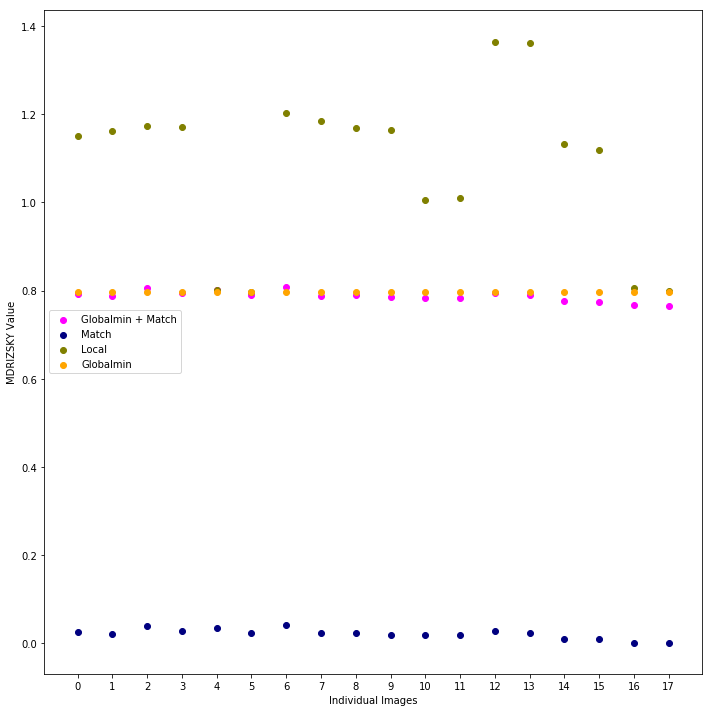

In [13]:
index = mdrizsky_val.index.tolist()
globalmin = list(mdrizsky_val['globalmin'])
globalmin_match = list(mdrizsky_val['globalmin_match'])
match = list(mdrizsky_val['match'])
local = list(mdrizsky_val['local'])

#Plotting code: 
fig = plt.figure(figsize=[10,10])
plt.scatter(index, globalmin_match, color='magenta', label='Globalmin + Match')
plt.scatter(index, match, color='navy', label='Match')
plt.scatter(index, local, color='olive', label='Local')
plt.scatter(index, globalmin, color = 'orange', label='Globalmin')
plt.xlabel('Individual Images')
plt.ylabel('MDRIZSKY Value')
plt.legend(loc="center left")
plt.xticks(index)
plt.tight_layout()

## 5. Display the full 'matched' mosaic 

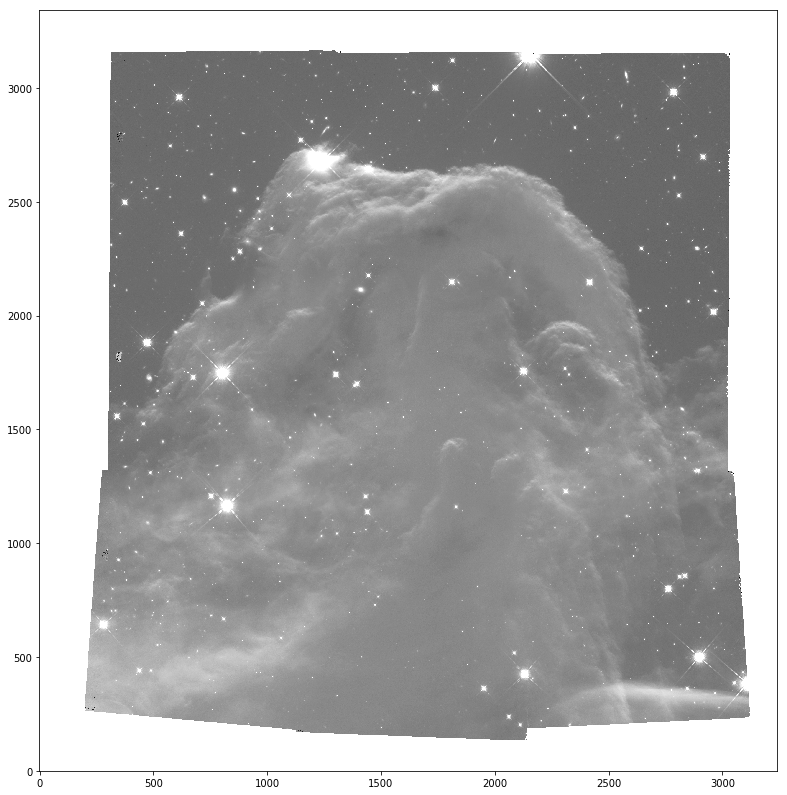

In [14]:
sci = fits.getdata('f160w_match_drz_sci.fits')
fig = plt.figure(figsize=(14, 14))
plt.imshow(sci, vmin=-0.4, vmax=3, cmap='Greys_r', origin='lower')

# About this Notebook

    Author: C. Martlin, STScI WFC3 Team  
    Updated: December, 14 2018